In [3]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D

import scipy.special
import math

from scipy.linalg import inv
from scipy.interpolate import make_interp_spline
from scipy.special import spherical_jn
from scipy.special import sph_harm
from scipy.interpolate import interp1d
from scipy import integrate

import camb
from camb import model, initialpower

import time as time

In [4]:
#CAMB (linear) Power Spectrum in Redshift = Z
# Cosmological parameters

Z=6

pars = camb.CAMBparams(scalar_amp=1,CMB_outputscale=1)

pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)

pars.InitPower.set_params(ns=0.965)

pars.set_matter_power(redshifts=[Z,], kmax=10.0)

# Getting the linear spectrum

pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 20000)


# interpolate CAMB's p(k):

P_camb=interp1d(kh,pk[0,:]/100,fill_value="extrapolate") # P em redshift 0 renormalizado por 1/100

dk1=np.abs(kh[1:]-kh[:-1])

In [5]:
# Dimensions of our box

linear_distance = 500 #Mpc/h #Box size

N_bins = 250 # number of bins per axis

Delta_L = linear_distance/N_bins #Mpc/h #Cell size

N_particles = 100*Delta_L**3*N_bins**3

N_bar = N_particles/(N_bins**3) # average density in particles/bin

xyz_edges = np.arange(0, linear_distance + 0.5, Delta_L)
xyz_centr = 0.5 * (xyz_edges[1:] + xyz_edges[:-1])

# This is the range of 'frequencies' for the box in the (numpy) Fourier space:

nbinsk = int(9*N_bins/10)
n_xyz = len(xyz_centr)
k_xyz = np.fft.fftfreq(n_xyz)


# These are the values of k in the grid:
ident = np.ones_like(k_xyz)
KX2 = np.einsum('i,j,k', k_xyz**2, ident, ident)
KY2 = np.einsum('i,j,k', ident, k_xyz**2, ident)
KZ2 = np.einsum('i,j,k', ident, ident, k_xyz**2)
grid_k = np.sqrt(KX2 + KY2 + KZ2)

k_max = 2*np.pi*np.max(k_xyz)/Delta_L
k_min = 2*np.pi/linear_distance

k_bins = np.arange(k_min, k_max, (k_max - k_min) / nbinsk)

k_ctrs = 0.5 * (k_bins[1:] + k_bins[:-1])
n_k = len(k_bins) - 1

# properties of each cell in real space

x=np.arange(N_bins)
x=x-N_bins/2
x_ones=np.ones_like(x)

x_grid = np.einsum('i,j,k', x, x_ones, x_ones)
y_grid = np.einsum('i,j,k', x_ones, x, x_ones)
z_grid = np.einsum('i,j,k', x_ones, x_ones, x)

r_grid = np.sqrt( x_grid**2 + y_grid**2 + z_grid**2 + 0.000001)

r_grid2 = np.sqrt( x_grid**2 + y_grid**2 + z_grid**2)

phi_grid=np.arctan2(y_grid,x_grid)

theta_grid=np.arccos(z_grid/r_grid)

cos_theta_grid=z_grid/r_grid

rho_grid=np.sqrt(x_grid**2+y_grid**2+0.000001)

sin_theta_grid=rho_grid/r_grid

sin_phi_grid=x_grid/rho_grid

cos_phi_grid=y_grid/rho_grid

d_Omega_grid=np.abs((sin_theta_grid*cos_phi_grid+sin_theta_grid*sin_phi_grid+cos_theta_grid)/(r_grid**2))

In [6]:
def kronecker(a,b):
    
    if a==b:
        
        return 1
    
    else:
        
        return 0

def pseudo_kronecker(a,b,W1):
    
    if abs(a-b)<W1:
        
        return (a-b)/W1
    
    else:
        
        return 0


def delta_lm(l3,delta,d_omega,norm,harm,mask):

    res=np.zeros(int(2*l3)+1,dtype='complex')
    
    for i in range(int(2*l3)+1):
        
        harm_m=harm[i,:,:,:]
        res[i]= np.sum ( d_omega * harm_m[mask] * delta ) 
        
    return norm * res

def compute_Harmonics(l2):
    
    res=np.zeros(shape=(int(2*l2)+1,N_bins,N_bins,N_bins),dtype='complex')
    m=np.linspace(-l2,l2,int(2*l2)+1)
    
    for i in range(len(m)):
        
        res[i,:,:,:]=np.conj(sph_harm(int(m[i]),int(l2),phi_grid,theta_grid))
    
    return res

def Angular_PS_tracers(N_sims,l1,b1,N1,r1,r2,W):
    
    

    res=np.zeros(shape=(N_sims,len(l1),len(b1),len(b1),len(r1),len(r2)),dtype='complex')
    

            
    for i in range(len(l1)):
        
        Harmonics=compute_Harmonics(l1[i])
            
        for a in range(N_sims):
            
            delta_tracers=random_delta_tracers(b1,N1)
            
            for u in range(len(b1)):
        
                delta_1=delta_tracers[u]
        
                for v in range(len(b1)):
            
                    delta_2=delta_tracers[v]
                    
                    
                    for j in range(len(r1)):
            
                        mask_r1=np.where((r_grid2>=(r1[j]/Delta_L-W/(2*Delta_L))) & (r_grid2<=(r1[j]/Delta_L+W/(2*Delta_L))))
                        norm_r1=4*np.pi/np.sum(d_Omega_grid[mask_r1])
                        d_omega_r1=d_Omega_grid[mask_r1]
                        delta_r1=delta_1[mask_r1]
                    
                        for k in range(len(r2)):
                
                            mask_r2=np.where((r_grid2>=(r2[k]/Delta_L-W/(2*Delta_L))) & (r_grid2<=(r2[k]/Delta_L+W/(2*Delta_L))))
                            norm_r2=4*np.pi/np.sum(d_Omega_grid[mask_r2])
                            d_omega_r2=d_Omega_grid[mask_r2]
                            delta_r2=delta_2[mask_r2]

                            deltas_lm_1=delta_lm(l1[i],delta_r1,d_omega_r1,norm_r1,Harmonics,mask_r1)
                            deltas_lm_2=np.conj(delta_lm(l1[i],delta_r2,d_omega_r2,norm_r2,Harmonics,mask_r2))
                
                            res[a,i,u,v,j,k]= np.mean( deltas_lm_1*deltas_lm_2 )
                
    return res

In [7]:
def tracer_cross_covariance(sim1,l1,b1,b2,b3,b4,r1,r2,r3,r4):
    
    l_index=int(np.where(l_1==np.double(l1))[0])
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])
    b3_index=int(np.where(biass==np.double(b3))[0])
    b4_index=int(np.where(biass==np.double(b4))[0])
    r1_index=int(np.where(r_1==np.double(r1))[0])
    r2_index=int(np.where(r_2==np.double(r2))[0])
    r3_index=int(np.where(r_1==np.double(r3))[0])
    r4_index=int(np.where(r_2==np.double(r4))[0])
    
    cl1=sim1[:,l_index,b1_index,b2_index,r1_index,r2_index]
    cl2=sim1[:,l_index,b3_index,b4_index,r3_index,r4_index]
    
    res = covariance_matrices(cl1,cl2)[0,1]
            
    return res

def tracer_cross_covariance_matrix_r1r2(sim1,l1,b1,b2,b3,b4,r3,r4):
    
    res=np.zeros(shape=(len(r_1),len(r_2)))
        
    for i in range(len(r_1)):
        for j in range(len(r_2)):
                
            res[i,j]=tracer_cross_covariance(sim1,l1,b1,b2,b3,b4,r_1[i],r_2[j],r3,r4)
            
    return res

def tracer_cross_covariance_matrix_r1r3(sim1,l1,b1,b2,b3,b4,r2,r4):
    
    res=np.zeros(shape=(len(r_1),len(r_1)))
        
    for i in range(len(r_1)):
        for j in range(len(r_1)):
                
            res[i,j]=tracer_cross_covariance(sim1,l1,b1,b2,b3,b4,r_1[i],r2,r_1[j],r4)
            
    return res

def tracer_norm_cross_covariance_matrix_r1r2(sim1,l1,b1,b2,b3,b4,r3,r4):
    
    res=np.zeros(shape=(len(r_1),len(r_2)))
    
    l_index=int(np.where(l_1==np.double(l1))[0])
    r3_index=int(np.where(r_1==r3)[0])
    r4_index=int(np.where(r_2==r4)[0])   
    
    for i in range(len(r_1)):
        for j in range(len(r_2)):
            
            res[i,j]=tracer_cross_covariance(sim1,l1,b1,b2,b3,b4,r_1[i],r_2[j],r3,r4)
    
    res=np.corrcoef(res)
    
    return res

def tracer_norm_cross_covariance_matrix_r1r3(sim1,l1,b1,b2,b3,b4,r2,r4):
    
    l_index=int(np.where(l_1==np.double(l1))[0])
    r2_index=int(np.where(r_2==r2)[0])
    r4_index=int(np.where(r_2==r4)[0])
    
    res=np.zeros(shape=(len(r_1),len(r_1)))
        
    for i in range(len(r_1)):
        for j in range(len(r_1)):
                
            res[i,j]=tracer_cross_covariance(sim1,l1,b1,b2,b3,b4,r_1[i],r2,r_1[j],r4)
            
    res=np.corrcoef(res)
                    
    return res

def plot_Cl_r1(sim1,simth1,l1,b1,b2,r2,W):
    
    l_index=int(np.where(l_1==np.double(l1))[0])
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])
    r2_index=int(np.where(r_2==r2)[0])   
    
    Cl_mean=np.zeros(len(r_1))
    Cl_theory=np.real(simth1[l_index,b1_index,b2_index,:,r2_index])
    Cl_var=np.zeros(len(r_1))
    
    for i in range(len(r_1)):
        
        Cl_mean[i]=np.mean(np.real(sim1[:,l_index,b1_index,b2_index,i,r2_index]))
        Cl_var[i]=np.sqrt(np.var(np.real(sim1[:,l_index,b1_index,b2_index,i,r2_index])))
    
    Cl_mean_interp=make_interp_spline(r_1,Cl_mean)
    
    Cl_var_interp=make_interp_spline(r_1,Cl_var)
    
    Cl_theory_interp=make_interp_spline(r_1,Cl_theory)
    
    r_interp=np.linspace(r_1[0],r_1[-1],5*len(r_1))
    
    fig, ax1 = plt.subplots(1,1)

    fig.set_figheight(10)
    fig.set_figwidth(10)
    
    ax1.plot(r_interp,Cl_mean_interp(r_interp),label='Simulation')
    ax1.plot(r_interp,Cl_theory_interp(r_interp),label='Theoretical')
    ax1.fill_between(r_interp,Cl_mean_interp(r_interp)-Cl_var_interp(r_interp),Cl_mean_interp(r_interp)+Cl_var_interp(r_interp),alpha=0.2)
    
    ax1.set_title(r"$C_{%i}^{%i\,%i}\,(\overline{r},%i)$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,b1,b2,r2,W),fontsize=20)
    ax1.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax1.set_ylabel(r"$C_{%i}^{%i\,%i}\,(\overline{r},%i)$"%(l1,b1,b2,r2),fontsize=15)
    
    ax1.set_xlim(left=r_1[0],right=r_1[-1])
    
    ax1.grid()
    ax1.legend(fontsize=16)

def plot_tracer_cov_r1r2(sim1,l1,b1,b2,b3,b4,r3,r4):
    
    fig, (ax1,ax2) = plt.subplots(1,2)

    fig.set_figheight(7)
    fig.set_figwidth(15)


    img1 = ax1.imshow(tracer_cross_covariance_matrix_r1r2(sim1,l1,b1,b2,b3,b4,r3,r4))
    img2 = ax2.imshow(tracer_norm_cross_covariance_matrix_r1r2(sim1,l1,b1,b2,b3,b4,r3,r4))

    ############

    ax1.set_xticks(np.linspace(0,len(r_1)-1,6));
    ax1.set_xticklabels(np.linspace(np.min(r_1),np.max(r_1),6))

    ax1.set_yticks(np.linspace(0,len(r_2)-1,11));
    ax1.set_yticklabels(np.linspace(np.min(r_2),np.max(r_2),11))

    ax1.set_title(r"$\sigma(\,C_{%i}^{%.1f \,, %.1f}\,(r_1,r_2),C_{%i}^{%.1f \,, %.1f}\,(%i,%i)\,)$" %(l1,b1,b2,l1,b3,b4,r3,r4),fontsize=15)
    ax1.set_xlabel(r"$r_1\,\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax1.set_ylabel(r"$r_2\,\,\,\,[Mpc\,h^{-1}]$",fontsize=15)

    #####

    ax2.set_xticks(np.linspace(0,len(r_1)-1,6));
    ax2.set_xticklabels(np.linspace(np.min(r_1),np.max(r_1),6))

    ax2.set_yticks(np.linspace(0,len(r_1)-1,11));
    ax2.set_yticklabels(np.linspace(np.min(r_1),np.max(r_1),11))

    ax2.set_title(r" Normalized $\sigma(\,C_{%i}^{%.1f \,, %.1f}\,(r_1,r_2),C_{%i}^{%.1f \,, %.1f}\,(%i,%i)\,)$" %(l1,b1,b2,l1,b3,b4,r3,r4),fontsize=15)
    ax2.set_xlabel(r"$r_1\,\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax2.set_ylabel(r"$r_2\,\,\,\,[Mpc\,h^{-1}]$",fontsize=15)

    ####


    fig.colorbar(img1,ax=ax1)
    fig.colorbar(img2,ax=ax2)


    plt.show()

def plot_tracer_cov_r1r3(sim1,l1,b1,b2,b3,b4,r2,r4):
    
    fig, (ax1,ax2) = plt.subplots(1,2)

    fig.set_figheight(7)
    fig.set_figwidth(15)


    img1 = ax1.imshow(tracer_cross_covariance_matrix_r1r3(sim1,l1,b1,b2,b3,b4,r2,r4))
    img2 = ax2.imshow(tracer_norm_cross_covariance_matrix_r1r3(sim1,l1,b1,b2,b3,b4,r2,r4))

    ############

    ax1.set_xticks(np.linspace(0,len(r_1)-1,6));
    ax1.set_xticklabels(np.linspace(np.min(r_1),np.max(r_1),6))

    ax1.set_yticks(np.linspace(0,len(r_2)-1,11));
    ax1.set_yticklabels(np.linspace(np.min(r_2),np.max(r_2),11))

    ax1.set_title(r"$\sigma(\,C_{%i}^{%.1f \,, %.1f}\,(r_1,%i),C_{%i}^{%.1f \,, %.1f}\,(r_3,%i)\,)$" %(l1,b1,b2,r2,l1,b3,b4,r4),fontsize=15)
    ax1.set_xlabel(r"$r_1\,\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax1.set_ylabel(r"$r_3\,\,\,\,[Mpc\,h^{-1}]$",fontsize=15)

    #####

    ax2.set_xticks(np.linspace(0,len(r_1)-1,6));
    ax2.set_xticklabels(np.linspace(np.min(r_1),np.max(r_1),6))

    ax2.set_yticks(np.linspace(0,len(r_1)-1,11));
    ax2.set_yticklabels(np.linspace(np.min(r_1),np.max(r_1),11))

    ax2.set_title(r" Normalized $\sigma(\,C_{%i}^{%.1f \,, %.1f}\,(r_1,%i),C_{%i}^{%.1f \,, %.1f}\,(r_3,%i)\,)$" %(l1,b1,b2,r2,l1,b3,b4,r4),fontsize=15)
    ax2.set_xlabel(r"$r_1\,\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax2.set_ylabel(r"$r_3\,\,\,\,[Mpc\,h^{-1}]$",fontsize=15)

    ####


    fig.colorbar(img1,ax=ax1)
    fig.colorbar(img2,ax=ax2)


    plt.show()
###########################################################################################################   # 

def plot_Cl_l(sim1,simth1,b1,b2,r1,r2,W):
    
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])
    r1_index=int(np.where(r_1==np.double(r1))[0]) 
    r2_index=int(np.where(r_2==np.double(r2))[0])   
    
    Cl_mean=np.zeros(len(l_1))
    Cl_min=np.zeros(len(l_1))
    Cl_max=np.zeros(len(l_1))
    Cl_theory=np.real(simth1[:,b1_index,b2_index,r1_index,r2_index])
    Cl_var=np.zeros(len(l_1))
    
    l2vec=np.linspace(0,l_1[-1],4*l_1[-1])
    
    for i in range(len(l_1)):
        
        Cl_mean[i]=np.mean(np.real(sim1[:,i,b1_index,b2_index,r1_index,r2_index]))
        Cl_min[i]=np.min(np.real(sim1[:,i,b1_index,b2_index,r1_index,r2_index]))
        Cl_max[i]=np.max(np.real(sim1[:,i,b1_index,b2_index,r1_index,r2_index]))
        Cl_var[i]=np.var(np.real(sim1[:,i,b1_index,b2_index,r1_index,r2_index]))

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

    fig.set_figheight(16)
    fig.set_figwidth(15)
    
    fig.suptitle(r"Simulation with bin width W = %i $\times\,\,%i\,\,Mpc\,h^{-1}$" %(W,Delta_L) , fontsize=20)
    
    ax1.plot(l_1,Cl_mean,label=r"Sample Mean")
    ax1.plot(l_1,Cl_theory,label=r"Theoretical")
    ax1.fill_between(l_1,Cl_mean-np.sqrt(Cl_var),Cl_mean+np.sqrt(Cl_var),alpha=0.2)
    ax1.set_title(r"$C_{\ell}^{%.1f,%.1f}(%i\,Mpc/h\,,%i\,Mpc/h\,)$"%(b1,b2,r1,r2),fontsize=20)
    ax1.legend(fontsize=14)
    ax1.set_xlim(left=0,right=l_1[-1])
    ax1.set_ylim(bottom=0,top=5e-4)
    ax1.set_xlabel(r"$\ell$",fontsize=20)
    ax1.grid()
    
    ax2.semilogx(l_1,l_1*(l_1+1)*Cl_mean/(4*np.pi),label=r"Sample Mean")
    ax2.semilogx(l_1,l_1*(l_1+1)*Cl_theory/(4*np.pi),label=r"Theoretical")
    ax2.fill_between(l_1,l_1*(l_1+1)*(Cl_mean-np.sqrt(Cl_var))/(4*np.pi),l_1*(l_1+1)*(Cl_mean+np.sqrt(Cl_var))/(4*np.pi),alpha=0.2)
    ax2.set_title(r"$\frac{\ell(\ell+1)}{4\pi}C_{\ell}^{%.1f,%.1f}(%i\,Mpc/h\,,%i\,Mpc/h\,)$"%(b1,b2,r1,r2),fontsize=20)
    ax2.legend(fontsize=14)
    ax2.set_xlim(left=1,right=l_1[-1])
    ax2.set_ylim(bottom=0,top=12e-3)
    ax2.set_xlabel(r"$\ell$",fontsize=20)
    ax2.grid()
    
    ax3.loglog(l_1,Cl_var/Cl_mean**2,label=r"divided by sample mean")
    ax3.loglog(l_1,Cl_var/Cl_theory**2,label=r"divided by theoretical value")
    ax3.set_title(r"$\frac{\sigma [C_{\ell}]}{<C_{\ell}>^2}$",fontsize=20)
    ax3.legend(fontsize=14)
    ax3.set_xlim(left=1,right=l_1[-1])
    ax3.set_xlabel(r"$\ell$",fontsize=20)
    ax3.grid()
    
    ax4.semilogx(kh2,P_camb(kh2),label=r"Top-Hat $P(k)$")
    ax4.fill_between(k_bins2,-10,P_camb(k_bins2),alpha=0.2,label=r"Toy Model Scale limits")
    ax4.set_xlim(left=kh2[0],right=kh2[-1])
    #ax4.set_ylim(bottom=-10)
    ax4.set_xlabel(r"$k\,\,\,[h\,Mpc^{-1}]$",fontsize=16)
    ax4.set_ylabel(r"$P(k)\,\,\,[Mpc^3\,h^{-3}]$",fontsize=16)
    ax4.set_title(r"Top-Hat Power Spectrum",fontsize=16)
    ax4.legend(fontsize=14)
    ax4.grid()
    
    plt.show()
    
    
def plot_Cl_r1r2(sim1,simth1,l1,b1,b2,W):
    
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])    
    l_index=int(np.where(l_1==np.double(l1))[0])
    
    Cl_mean=np.zeros(shape=(len(r_1),len(r_1)))
    
    for i in range(len(r_1)):
        for j in range(len(r_2)):
            
            Cl_mean[i,j]=np.real(np.mean(sim1[:,l_index,b1_index,b2_index,i,j]))
    
    Cl_theory=np.real(simth1[l_index,b1_index,b2_index,:,:])
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

    fig.set_figheight(15)
    fig.set_figwidth(22)
    
    ####
    
    img1 = ax1.imshow(Cl_mean)
    
    ax1.set_title(r"$C_{%i,obs}^{%i\,%i}\,(\overline{r},\overline{r}')$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,b1,b2,W),fontsize=20)
    ax1.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax1.set_ylabel(r"$\overline{r}'\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    
    ax1.set_xticks(np.linspace(0,len(r_1)-1,6));
    ax1.set_xticklabels(np.linspace(np.min(r_1),np.max(r_1),6))

    ax1.set_yticks(np.linspace(0,len(r_1)-1,11));
    ax1.set_yticklabels(np.linspace(np.min(r_1),np.max(r_1),11))
    
    fig.colorbar(img1,ax=ax1,fraction=0.046, pad=0.04)
    
    #####
    
    img2 = ax2.imshow(Cl_theory)
    
    ax2.set_title(r"$ C_{%i,th}^{%i\,%i}\,(\overline{r},\overline{r}')$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,b1,b2,W),fontsize=20)
    ax2.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax2.set_ylabel(r"$\overline{r}'\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    
    ax2.set_xticks(np.linspace(0,len(r_1)-1,6));
    ax2.set_xticklabels(np.linspace(np.min(r_1),np.max(r_1),6))

    ax2.set_yticks(np.linspace(0,len(r_1)-1,11));
    ax2.set_yticklabels(np.linspace(np.min(r_1),np.max(r_1),11))
    
    fig.colorbar(img2,ax=ax2,fraction=0.046, pad=0.04)
    
    #####
    
    residual1=(Cl_mean-Cl_theory)/Cl_theory
    
    img3 = ax3.imshow(residual1,cmap='bwr')
    img3.set_clim(-1, 1)
    fig.colorbar(img3,ax=ax3,fraction=0.046, pad=0.04)
    ax3.set_xticks(np.linspace(0,len(r_1)-1,6));
    ax3.set_xticklabels(np.linspace(np.min(r_1),np.max(r_1),6))

    ax3.set_yticks(np.linspace(0,len(r_1)-1,11));
    ax3.set_yticklabels(np.linspace(np.min(r_1),np.max(r_1),11))
    ax3.set_title(r"Residual $(C_{obs}-C_{th})/C_{th}$" ,fontsize=20)
    ax3.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax3.set_ylabel(r"$\overline{r}'\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    
    #### Cl_r1r1 plot   

    Cl_r1r1=np.zeros(shape=(len(r_1)))
    Cl_r1r1_var=np.zeros(shape=(len(r_1)))
    Cl_r1r1_theory=np.zeros(shape=(len(r_1)))
    Cl_r1r1_var_theory=np.zeros(shape=(len(r_1)))
    
    for i in range(len(r_1)):
     
        Cl_r1r1[i]=np.real(np.mean(sim1[:,l_index,b1_index,b2_index,i,i]))
        
        Cl_r1r1_var[i]=np.sqrt(np.var(sim1[:,l_index,b1_index,b2_index,i,i]))
        
        Cl_r1r1_theory[i]=np.real(simth1[l_index,b1_index,b2_index,i,i])
    
    for i in range(len(r_1)):
        
        Cl_r1r1_var_theory[i]=np.sqrt(2*Cl_r1r1_theory[i]**2/(2*l1+1))
        
    Cl_mean_interp=make_interp_spline(r_1,Cl_r1r1)
    
    Cl_var_interp=make_interp_spline(r_1,Cl_r1r1_var)
    
    Cl_theory_interp=make_interp_spline(r_1,Cl_r1r1_theory)
    
    Cl_var_th_interp=make_interp_spline(r_1,Cl_r1r1_var_theory)
    
    r_interp=np.linspace(r_1[0],r_1[-1],5*len(r_1))
    
    ####
    
    ax4.semilogy(r_interp,Cl_mean_interp(r_interp),label='Simulation')
    ax4.semilogy(r_interp,Cl_theory_interp(r_interp),label='Theoretical')
    ax4.fill_between(r_interp,Cl_mean_interp(r_interp)-Cl_var_interp(r_interp),Cl_mean_interp(r_interp)+Cl_var_interp(r_interp),alpha=0.2)
    ax4.fill_between(r_interp,Cl_theory_interp(r_interp)-Cl_var_th_interp(r_interp),Cl_theory_interp(r_interp)+Cl_var_th_interp(r_interp),alpha=0.2)
    ax4.set_title(r"$C_{%i}^{%i\,%i}\,(\overline{r},\overline{r})$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,b1,b2,W),fontsize=20)
    ax4.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax4.set_ylabel(r"$C_{%i}^{%i\,%i}\,(\overline{r},\overline{r})$"%(l1,b1,b2),fontsize=15)
    
    ax4.set_xlim(left=r_1[0],right=r_1[-1])
    #ax4.set_ylim(bottom=1e-5)
    ax4.grid()
    ax4.legend(fontsize=16)
    
def plot_Corr_Cl_r1r2(sim1,simth1,sim_inf,l1,b1,b2,W):
    
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])    
    l_index=int(np.where(l_1==np.double(l1))[0])
    
    Cl_mean=np.zeros(shape=(len(r_1),len(r_1)))
    
    for i in range(len(r_1)):
        for j in range(len(r_2)):
            
            Cl_mean[i,j]=np.real(np.mean(sim1[:,l_index,b1_index,b2_index,i,j]))
    
    Cl_theory=np.real(simth1[l_index,b1_index,b2_index,:,:])
    Cl_theory_inf=np.real(sim_inf[l_index,b1_index,b2_index,:,:])
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3)

    fig.set_figheight(7)
    fig.set_figwidth(21)
    ####
    
    cd=Cl_mean
    ct=Cl_theory
    ct_inf=Cl_theory_inf
    diag_cd=np.diagonal(cd)
    diag_ct=np.diagonal(ct)
    diag_ct_inf=np.diagonal(ct_inf)
    norm_cd=np.outer(np.sqrt(diag_cd),np.sqrt(diag_cd))
    norm_ct=np.outer(np.sqrt(diag_ct),np.sqrt(diag_ct))
    norm_ct_inf=np.outer(np.sqrt(diag_ct_inf),np.sqrt(diag_ct_inf))
    cd_norm=cd/norm_cd
    ct_norm=ct/norm_ct
    ct_norm_inf=ct_inf/norm_ct_inf
    #residual=cd_norm-ct_norm
    
    
    ####
    
    img1 = ax1.imshow(ct_norm_inf)
    
    ax1.set_title(r"$Corr_{\ell,Th}\,(r,r\,')$ , $\ell=%i$"%l1,fontsize=25)
    ax1.set_xlabel(r"$\overline{r}\,\,\,[\,h^{-1}\,Mpc\,]$",fontsize=25)
    ax1.set_ylabel(r"$\overline{r}\,'\,\,\,[\,h^{-1}\,Mpc\,]$",fontsize=25)
    
    ax1.set_xticks((int(3.5*len(r_inf)/len(r_1)),int(7.5*len(r_inf)/len(r_1)),int(11.5*len(r_inf)/len(r_1)),int(15.5*len(r_inf)/len(r_1)),int(19.5*len(r_inf)/len(r_1)),int(23.5*len(r_inf)/len(r_1))));
    ax1.set_xticklabels((40,80,120,160,200,240))

    ax1.set_yticks((int(3.5*len(r_inf)/len(r_1)),int(7.5*len(r_inf)/len(r_1)),int(11.5*len(r_inf)/len(r_1)),int(15.5*len(r_inf)/len(r_1)),int(19.5*len(r_inf)/len(r_1)),int(23.5*len(r_inf)/len(r_1))));
    ax1.set_yticklabels((40,80,120,160,200,240))
    ax1.tick_params(labelsize=20) 
    
    
    ####
    
    img2 = ax2.imshow(ct_norm)
    
    ax2.set_title(r"$Corr_{\ell,Th}\,(\overline{r},\overline{r}\,')$ , $\ell=%i$"%l1,fontsize=25)
    ax2.set_xlabel(r"$\overline{r}\,\,\,[\,h^{-1}\,Mpc\,]$",fontsize=25)
    
    ax2.set_xticks((3.5,7.5,11.5,15.5,19.5,23.5));
    ax2.set_xticklabels((40,80,120,160,200,240))

    ax2.tick_params(labelleft=False,left=False,right=False,labelsize=20)
    
    #####
    
    img3 = ax3.imshow(cd_norm)
    
    ax3.set_title(r"$Corr_{\ell,Sim}\,(\overline{r},\overline{r}\,')$ , $\ell=%i$"%l1,fontsize=25)
    ax3.set_xlabel(r"$\overline{r}\,\,\,[\,h^{-1}\,Mpc\,]$",fontsize=25)
    
    ax3.set_xticks((3.5,7.5,11.5,15.5,19.5,23.5));
    ax3.set_xticklabels((40,80,120,160,200,240))

    ax3.set_yticks((3.5,7.5,11.5,15.5,19.5,23.5));
    ax3.set_yticklabels((40,80,120,160,200,240))
    ax3.yaxis.set_ticks_position("right")

    #cbar=fig.colorbar(img3,ax=[ax1,ax2,ax3],fraction=0.046, pad=0.04)
    #cbar.ax.tick_params(labelsize=20)
    
    ax3.tick_params(labelsize=20)
    

    #### Cl_r1r1 plot   

    Cl_r1r1=np.zeros(shape=(len(r_1)))
    Cl_r1r1_var=np.zeros(shape=(len(r_1)))
    Cl_r1r1_theory=np.zeros(shape=(len(r_1)))
    Cl_r1r1_var_theory=np.zeros(shape=(len(r_1)))
    
    for i in range(len(r_1)):
     
        Cl_r1r1[i]=np.real(np.mean(sim1[:,l_index,b1_index,b2_index,i,i]))
        
        Cl_r1r1_var[i]=np.sqrt(np.var(sim1[:,l_index,b1_index,b2_index,i,i]))
        
        Cl_r1r1_theory[i]=np.real(simth1[l_index,b1_index,b2_index,i,i])
    
    for i in range(len(r_1)):
        
        Cl_r1r1_var_theory[i]=np.sqrt(2*Cl_r1r1_theory[i]**2/(2*l1+1))
        
    Cl_mean_interp=make_interp_spline(r_1,Cl_r1r1)
    
    Cl_var_interp=make_interp_spline(r_1,Cl_r1r1_var)
    
    Cl_theory_interp=make_interp_spline(r_1,Cl_r1r1_theory)
    
    Cl_var_th_interp=make_interp_spline(r_1,Cl_r1r1_var_theory)
    
    r_interp=np.linspace(r_1[0],r_1[-1],5*len(r_1))
    
    ####
    
    plt.figure(figsize=(21,7))
    plt.semilogy(r_interp,Cl_mean_interp(r_interp),label='Simulação')
    plt.semilogy(r_interp,Cl_theory_interp(r_interp),label='Teórico')
    plt.fill_between(r_interp,Cl_mean_interp(r_interp)-Cl_var_interp(r_interp),Cl_mean_interp(r_interp)+Cl_var_interp(r_interp),alpha=0.2)
    plt.fill_between(r_interp,Cl_theory_interp(r_interp)-Cl_var_th_interp(r_interp),Cl_theory_interp(r_interp)+Cl_var_th_interp(r_interp),alpha=0.2)
    plt.title(r"$C_{\ell}\,(\,\overline{r},\overline{r}\,)$ , $\ell=%i$"%(l1),fontsize=25)
    plt.xlabel(r"$\overline{r}\,\,\,[\,h^{-1}\,Mpc\,]$",fontsize=25)
    plt.ylabel(r"$C_{\ell}\,(\overline{r},\overline{r})$",fontsize=25)
    plt.ylim(bottom=1e-6,top=4e-3)
    plt.xlim(left=r_1[0],right=r_1[-1])
    plt.tick_params(labelsize=25)
    plt.grid()
    plt.legend(fontsize=18)
    
def plot_Cl_r1r2_norm(sim1,simth1,l1,b1,b2,W):
    
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])    
    l_index=int(np.where(l_1==np.double(l1))[0])
    
    Cl_mean=np.zeros(shape=(len(r_1),len(r_1)))
    
    for i in range(len(r_1)):
        for j in range(len(r_2)):
            
            Cl_mean[i,j]=np.real(np.mean(sim1[:,l_index,b1_index,b2_index,i,j]))
    
    Cl_theory=np.real(simth1[l_index,b1_index,b2_index,:,:])
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

    fig.set_figheight(15)
    fig.set_figwidth(22)
    
    ####
    
    diag_cd=np.diagonal(Cl_mean)
    diag_ct=np.diagonal(Cl_theory)
    norm_cd=np.outer(np.sqrt(diag_cd),np.sqrt(diag_cd))
    norm_ct=np.outer(np.sqrt(diag_ct),np.sqrt(diag_ct))
    cd_norm=Cl_mean/norm_cd
    ct_norm=Cl_theory/norm_ct 
    residual=cd_norm-ct_norm
    
    #####
    
    img1 = ax1.imshow(cd_norm)
    
    ax1.set_title(r" Normalized $C_{%i,obs}^{%i\,%i}\,(\overline{r},\overline{r}')$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,b1,b2,W),fontsize=20)
    ax1.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax1.set_ylabel(r"$\overline{r}'\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    
    ax1.set_xticks(np.linspace(0,len(r_1)-1,6));
    ax1.set_xticklabels(np.linspace(np.min(r_1),np.max(r_1),6))

    ax1.set_yticks(np.linspace(0,len(r_1)-1,11));
    ax1.set_yticklabels(np.linspace(np.min(r_1),np.max(r_1),11))
    
    fig.colorbar(img1,ax=ax1,fraction=0.046, pad=0.04)
    
    #####
    
    img2 = ax2.imshow(ct_norm)
    
    ax2.set_title(r" Normalized $ C_{%i,th}^{%i\,%i}\,(\overline{r},\overline{r}')$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,b1,b2,W),fontsize=20)
    ax2.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax2.set_ylabel(r"$\overline{r}'\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    
    ax2.set_xticks(np.linspace(0,len(r_1)-1,6));
    ax2.set_xticklabels(np.linspace(np.min(r_1),np.max(r_1),6))

    ax2.set_yticks(np.linspace(0,len(r_1)-1,11));
    ax2.set_yticklabels(np.linspace(np.min(r_1),np.max(r_1),11))
    
    fig.colorbar(img2,ax=ax2,fraction=0.046, pad=0.04)
    
    #####
    
    
    img3 = ax3.imshow(residual,cmap='bwr')
    img3.set_clim(-1, 1)
    fig.colorbar(img3,ax=ax3,fraction=0.046, pad=0.04)
    ax3.set_xticks(np.linspace(0,len(r_1)-1,6));
    ax3.set_xticklabels(np.linspace(np.min(r_1),np.max(r_1),6))

    ax3.set_yticks(np.linspace(0,len(r_1)-1,11));
    ax3.set_yticklabels(np.linspace(np.min(r_1),np.max(r_1),11))
    ax3.set_title(r"Residual $(C_{obs}-C_{th})/C_{th}$" ,fontsize=20)
    ax3.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax3.set_ylabel(r"$\overline{r}'\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    
    #### Cl_r1r1 plot   

    Cl_r1r1=np.zeros(shape=(len(r_1)))
    Cl_r1r1_var=np.zeros(shape=(len(r_1)))
    Cl_r1r1_theory=np.zeros(shape=(len(r_1)))
    Cl_r1r1_var_theory=np.zeros(shape=(len(r_1)))
    
    for i in range(len(r_1)):
     
        Cl_r1r1[i]=np.real(np.mean(sim1[:,l_index,b1_index,b2_index,i,i]))
        
        Cl_r1r1_var[i]=np.sqrt(np.var(sim1[:,l_index,b1_index,b2_index,i,i]))
        
        Cl_r1r1_theory[i]=np.real(simth1[l_index,b1_index,b2_index,i,i])
    
    for i in range(len(r_1)):
        
        Cl_r1r1_var_theory[i]=np.sqrt(2*Cl_r1r1_theory[i]**2/(2*l1+1))
        
    Cl_mean_interp=make_interp_spline(r_1,Cl_r1r1)
    
    Cl_var_interp=make_interp_spline(r_1,Cl_r1r1_var)
    
    Cl_theory_interp=make_interp_spline(r_1,Cl_r1r1_theory)
    
    Cl_var_th_interp=make_interp_spline(r_1,Cl_r1r1_var_theory)
    
    r_interp=np.linspace(r_1[0],r_1[-1],5*len(r_1))
    
    ####
    
    ax4.semilogy(r_interp,Cl_mean_interp(r_interp),label='Simulation')
    ax4.semilogy(r_interp,Cl_theory_interp(r_interp),label='Theoretical')
    ax4.fill_between(r_interp,Cl_mean_interp(r_interp)-Cl_var_interp(r_interp),Cl_mean_interp(r_interp)+Cl_var_interp(r_interp),alpha=0.2)
    ax4.fill_between(r_interp,Cl_theory_interp(r_interp)-Cl_var_th_interp(r_interp),Cl_theory_interp(r_interp)+Cl_var_th_interp(r_interp),alpha=0.2)
    ax4.set_title(r"$C_{%i}^{%i\,%i}\,(\overline{r},\overline{r})$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,b1,b2,W),fontsize=20)
    ax4.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax4.set_ylabel(r"$C_{%i}^{%i\,%i}\,(\overline{r},\overline{r})$"%(l1,b1,b2),fontsize=15)
    
    ax4.set_xlim(left=r_1[0],right=r_1[-1])
    
    ax4.grid()
    ax4.legend(fontsize=16)
    
def plot_Cl_r1r1(sim1,simth1,l1,b1,b2,W):
    
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])    
    l_index=int(np.where(l_1==np.double(l1))[0])
    
    Cl_mean=np.zeros(shape=(len(r_1)))
    Cl_var=np.zeros(shape=(len(r_1)))
    Cl_theory=np.zeros(shape=(len(r_1)))
    
    for i in range(len(r_1)):
     
        Cl_mean[i]=np.real(np.mean(sim1[:,l_index,b1_index,b2_index,i,i]))
        
        Cl_var[i]=np.sqrt(np.var(sim1[:,l_index,b1_index,b2_index,i,i]))
        
        Cl_theory[i]=np.real(simth1[l_index,b1_index,b2_index,i,i])
    
    
    Cl_mean_interp=make_interp_spline(r_1,Cl_mean)
    
    Cl_var_interp=make_interp_spline(r_1,Cl_var)
    
    Cl_theory_interp=make_interp_spline(r_1,Cl_theory)
    
    r_interp=np.linspace(r_1[0],r_1[-1],5*len(r_1))
    
    fig, ax1 = plt.subplots(1,1)

    fig.set_figheight(10)
    fig.set_figwidth(10)
    
    ####
    
    ax1.semilogy(r_interp,Cl_mean_interp(r_interp),label='Simulation')
    ax1.semilogy(r_interp,Cl_theory_interp(r_interp),label='Theoretical')
    ax1.fill_between(r_interp,Cl_mean_interp(r_interp)-Cl_var_interp(r_interp),Cl_mean_interp(r_interp)+Cl_var_interp(r_interp),alpha=0.2)
    
    ax1.set_title(r"$C_{%i}^{%i\,%i}\,(\overline{r},\overline{r})$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,b1,b2,W),fontsize=20)
    ax1.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax1.set_ylabel(r"$C_{%i}^{%i\,%i}\,(\overline{r},\overline{r})$"%(l1,b1,b2),fontsize=15)
    
    ax1.set_xlim(left=r_1[0],right=r_1[-1])
    
    ax1.grid()
    ax1.legend(fontsize=16)
    


In [8]:
def cov_XY(sim1,simth1,l1,b1,b2,b3,b4,W):
    
    l_index=int(np.where(l_1==np.double(l1))[0])
    
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])
    b3_index=int(np.where(biass==np.double(b3))[0])
    b4_index=int(np.where(biass==np.double(b4))[0])
    
    r1len=len(sim1[0,0,0,0,:,0])
    
    simsampleslen=len(sim1[:,0,0,0,0,0])
    
    cl1sim=np.real(sim1[:,l_index,b1_index,b2_index,:,:])
    cl2sim=np.real(sim1[:,l_index,b3_index,b4_index,:,:])   
    
    Xlen=math.comb(r1len+1, 2)      
    
    CLX_vec_samples=np.zeros(shape=(simsampleslen,Xlen))
    CLY_vec_samples=np.zeros(shape=(simsampleslen,Xlen))
    
    CL1_vec_theory=np.real(simth1[l_index,b1_index,b3_index,:,:])
    CL2_vec_theory=np.real(simth1[l_index,b2_index,b4_index,:,:])
    CL3_vec_theory=np.real(simth1[l_index,b1_index,b4_index,:,:])
    CL4_vec_theory=np.real(simth1[l_index,b3_index,b2_index,:,:])
    
    for i in range(simsampleslen):
        
        CLX_vec_samples[i][:]=cl1sim[i][np.triu_indices(r1len)]
        CLY_vec_samples[i][:]=cl2sim[i][np.triu_indices(r1len)]  
            
    covmatrix=np.zeros(shape=(Xlen,Xlen))
    covmatrix_theory=np.zeros(shape=(Xlen,Xlen))
    
    
    for i in range(Xlen):
        for j in range(Xlen):
            
            if j<=i:
                
                r1_index=np.triu_indices(r1len)[0][i]
                r2_index=np.triu_indices(r1len)[1][i]
                r3_index=np.triu_indices(r1len)[0][j]
                r4_index=np.triu_indices(r1len)[1][j]
                
                covmatrix[i,j]=np.cov(CLX_vec_samples[:,i],CLY_vec_samples[:,j])[0,1]
                
                covmatrix_theory[i,j]=(1/(2*l1+1))*(CL1_vec_theory[r1_index,r3_index]*CL2_vec_theory[r2_index,r4_index]+CL3_vec_theory[r1_index,r4_index]*CL4_vec_theory[r3_index,r2_index])
        
    for i in range(Xlen):
        for j in range(Xlen):    
    
            if j>i:
                covmatrix[i,j]=covmatrix[j,i]
                covmatrix_theory[i,j]=covmatrix_theory[j,i]
                
    return covmatrix,covmatrix_theory


def complete_cov_r1r2r3r4(sim1,simth1,l1,b1,b2,b3,b4,W):
    
    l_index=int(np.where(l_1==np.double(l1))[0])
    
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])
    b3_index=int(np.where(biass==np.double(b3))[0])
    b4_index=int(np.where(biass==np.double(b4))[0])
    
    r1len=len(sim1[0,0,0,0,:,0])
    
    simsampleslen=len(sim1[:,0,0,0,0,0])
    
    cl1sim=np.real(sim1[:,l_index,b1_index,b2_index,:,:])
    cl2sim=np.real(sim1[:,l_index,b3_index,b4_index,:,:])   
    
    Xlen=r1len**2   
    
    CLX_vec_samples=np.zeros(shape=(simsampleslen,Xlen))
    CLY_vec_samples=np.zeros(shape=(simsampleslen,Xlen))
    
    CL1_vec_theory=np.real(simth1[l_index,b1_index,b3_index,:,:])
    CL2_vec_theory=np.real(simth1[l_index,b2_index,b4_index,:,:])
    CL3_vec_theory=np.real(simth1[l_index,b1_index,b4_index,:,:])
    CL4_vec_theory=np.real(simth1[l_index,b3_index,b2_index,:,:])
    
    for i in range(simsampleslen):
        
        CLX_vec_samples[i][:]=np.matrix.flatten(cl1sim[i,:,:])
        CLY_vec_samples[i][:]=np.matrix.flatten(cl2sim[i,:,:] )
            
    covmatrix=np.zeros(shape=(Xlen,Xlen))
    covmatrix_theory=np.zeros(shape=(Xlen,Xlen))
    
    
    for i in range(Xlen):
        for j in range(Xlen):
            
            if j<=i:
                
                r1_index=np.unravel_index([i], (r1len,r1len))[0]
                r2_index=np.unravel_index([i], (r1len,r1len))[1]
                r3_index=np.unravel_index([j], (r1len,r1len))[0]
                r4_index=np.unravel_index([j], (r1len,r1len))[1]
                
                covmatrix[i,j]=np.cov(CLX_vec_samples[:,i],CLY_vec_samples[:,j])[0,1]
                
                covmatrix_theory[i,j]=(CL1_vec_theory[r1_index,r3_index]*CL2_vec_theory[r2_index,r4_index]+CL3_vec_theory[r1_index,r4_index]*CL4_vec_theory[r3_index,r2_index])/(2*l1+1)
        
    for i in range(Xlen):
        for j in range(Xlen):    
    
            if j>i:
                covmatrix[i,j]=covmatrix[j,i]
                covmatrix_theory[i,j]=covmatrix_theory[j,i]
                
    return covmatrix,covmatrix_theory

In [9]:
def plot_tracer_cov_XY(sim1,simth1,l1,b1,b2,b3,b4,W):
    
    cd,ct=cov_XY(sim1,simth1,l1,b1,b2,b3,b4,W)
                          
    residual=(cd-ct)/(ct) 
    
    fig, (ax1,ax2) = plt.subplots(1,2)

    fig.set_figheight(10)
    fig.set_figwidth(22)


    img1 = ax1.imshow(cd,cmap='bwr')
    
    ax1.set_title(r"$\sigma\,[\,\xi_{%i}^{\mathbf{X}}\,,\,\xi_{%i}^{\mathbf{Y}}\,]$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,l1,W),fontsize=20)
    ax1.set_xlabel(r"$\mathbf{X}$",fontsize=15)
    ax1.set_ylabel(r"$\mathbf{Y}$",fontsize=15)
    
    fig.colorbar(img1,ax=ax1,fraction=0.046, pad=0.04)
    
    img2 = ax2.imshow(ct,cmap='bwr')
    
    ax2.set_title(r"Theoretical $\sigma\,[\,\xi_{%i}^{\mathbf{X}}\,,\,\xi_{%i}^{\mathbf{Y}}\,]$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,l1,W),fontsize=20)
    ax2.set_xlabel(r"$\mathbf{X}$",fontsize=15)
    ax2.set_ylabel(r"$\mathbf{Y}$",fontsize=15)
    
    fig.colorbar(img2,ax=ax2,fraction=0.046, pad=0.04)
    
    #######
    
    fig2, ax3 = plt.subplots(1,1)

    fig2.set_figheight(8)
    fig2.set_figwidth(8)
    
    img3 = ax3.imshow(residual,cmap='bwr')
    fig2.colorbar(img3,ax=ax3,fraction=0.046, pad=0.04)
    
    ax3.set_title(r"Residual $(\sigma_{obs}-\sigma_{th})/\sigma_{th}$",fontsize=20)
    ax3.set_xlabel(r"$\mathbf{X}$",fontsize=15)
    ax3.set_ylabel(r"$\mathbf{Y}$",fontsize=15)
    
    min_th=np.min(ct)
    min_sim=np.min(cd)
    
    img1.set_clim(-1e-9, 1e-9)
    img2.set_clim(-1e-9, 1e-9)
    img3.set_clim(-2, 2)
    
def plot_complete_tracer_cov_XY(sim1,simth1,l1,b1,b2,b3,b4,W):
    
    cd,ct=complete_cov_r1r2r3r4(sim1,simth1,l1,b1,b2,b3,b4,W)
                          
    residual=(cd-ct)/(ct) 
    
    fig, (ax1,ax2) = plt.subplots(1,2)

    fig.set_figheight(10)
    fig.set_figwidth(22)


    img1 = ax1.imshow(cd,cmap='bwr')
    
    ax1.set_title(r"$\sigma\,[\,\xi_{%i}^{\mathbf{X}}\,,\,\xi_{%i}^{\mathbf{Y}}\,]$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,l1,W),fontsize=20)
    ax1.set_xlabel(r"$\mathbf{X}$",fontsize=15)
    ax1.set_ylabel(r"$\mathbf{Y}$",fontsize=15)
    
    fig.colorbar(img1,ax=ax1,fraction=0.046, pad=0.04)
    
    img2 = ax2.imshow(ct,cmap='bwr')
    
    ax2.set_title(r"Theoretical $\sigma\,[\,\xi_{%i}^{\mathbf{X}}\,,\,\xi_{%i}^{\mathbf{Y}}\,]$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,l1,W),fontsize=20)
    ax2.set_xlabel(r"$\mathbf{X}$",fontsize=15)
    ax2.set_ylabel(r"$\mathbf{Y}$",fontsize=15)
    
    fig.colorbar(img2,ax=ax2,fraction=0.046, pad=0.04)
    

    #######
    
    fig2, ax3 = plt.subplots(1,1)

    fig2.set_figheight(8)
    fig2.set_figwidth(8)
    
    img3 = ax3.imshow(residual,cmap='bwr')
    fig2.colorbar(img3,ax=ax3,fraction=0.046, pad=0.04)
    
    ax3.set_title(r"Residual $(\sigma_{obs}-\sigma_{th})/\sigma_{th}$",fontsize=20)
    ax3.set_xlabel(r"$\mathbf{X}$",fontsize=15)
    ax3.set_ylabel(r"$\mathbf{Y}$",fontsize=15)
    
    img1.set_clim(-1e-9, 1e-9)
    img2.set_clim(-1e-9, 1e-9)
    img3.set_clim(-2, 2)
    
def plot_tracer_cov_XY_norm(sim1,simth1,l1,b1,b2,b3,b4,W):
              
    cd,ct=cov_XY(sim1,simth1,l1,b1,b2,b3,b4,W)
    diag_cd=np.diagonal(cd)
    diag_ct=np.diagonal(ct)
    norm_cd=np.outer(np.sqrt(diag_cd),np.sqrt(diag_cd))
    norm_ct=np.outer(np.sqrt(diag_ct),np.sqrt(diag_ct))
    cd_norm=cd/norm_cd
    ct_norm=ct/norm_ct 
    residual=cd_norm-ct_norm
    
    fig, (ax1,ax2) = plt.subplots(1,2)

    fig.set_figheight(10)
    fig.set_figwidth(22)


    img1 = ax1.imshow(cd_norm,cmap='bwr')
    img1.set_clim(-1, 1)
    
    ax1.set_title(r"$\sigma_{norm}\,[\,\xi_{%i,obs}^{\mathbf{X}}\,,\,\xi_{%i,obs}^{\mathbf{Y}}\,]$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,l1,W),fontsize=20)
    ax1.set_xlabel(r"$\mathbf{X}$",fontsize=15)
    ax1.set_ylabel(r"$\mathbf{Y}$",fontsize=15)
    
    fig.colorbar(img1,ax=ax1,fraction=0.046, pad=0.04)
    
    img2 = ax2.imshow(ct_norm,cmap='bwr')
    img2.set_clim(-1, 1)
    
    ax2.set_title(r"$\sigma_{norm}\,[\,\xi_{%i,th}^{\mathbf{X}}\,,\,\xi_{%i,th}^{\mathbf{Y}}\,]$ with bin width W = $%i\,\,Mpc\,h^{-1}$"%(l1,l1,W),fontsize=20)
    ax2.set_xlabel(r"$\mathbf{X}$",fontsize=15)
    ax2.set_ylabel(r"$\mathbf{Y}$",fontsize=15)
    
    fig.colorbar(img2,ax=ax2,fraction=0.046, pad=0.04)
    
    #######
    
    fig2, ax3 = plt.subplots(1,1)

    fig2.set_figheight(8)
    fig2.set_figwidth(8)
    
    img3 = ax3.imshow(residual,cmap='bwr')
    img3.set_clim(-1, 1)
    
    fig2.colorbar(img3,ax=ax3,fraction=0.046, pad=0.04)
    
    ax3.set_title(r"Residual $\sigma_{obs}-\sigma_{th}$",fontsize=20)
    ax3.set_xlabel(r"$\mathbf{X}$",fontsize=15)
    ax3.set_ylabel(r"$\mathbf{Y}$",fontsize=15)
    
def plot_complete_tracer_cov_XY_norm(sim1,simth1,l1,b1,b2,b3,b4,W,Nf):
              
    cd,ct=complete_cov_r1r2r3r4(sim1,simth1,l1,b1,b2,b3,b4,W)
    diag_cd=np.diagonal(cd)
    diag_ct=np.diagonal(ct)
    norm_cd=np.outer(np.sqrt(diag_cd),np.sqrt(diag_cd))
    norm_ct=np.outer(np.sqrt(diag_ct),np.sqrt(diag_ct))
    cd_norm=Nf*cd/norm_cd
    ct_norm=ct/norm_ct 
    residual=cd_norm-ct_norm
    
    MSE = np.sum((cd_norm-ct_norm)**2)
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

    fig.set_figheight(20)
    fig.set_figwidth(22)


    img1 = ax1.imshow(cd_norm,cmap='bwr',origin="lower")
    img1.set_clim(-1, 1)
    ax1.set_title(r"$Corr\,[\xi_{\ell}(\mathbf{X}),\xi_{\ell}(\mathbf{Y})]$ Amostral, $\ell=%i$"%l1 ,fontsize=20)
    ax1.set_xlabel(r"$\mathbf{X}$",fontsize=20)
    ax1.set_ylabel(r"$\mathbf{Y}$",fontsize=20)
    ax1.tick_params(labelsize=20)
    
    axins = ax1.inset_axes([0.5, 0.03, 0.47, 0.47])
    img12=axins.imshow(cd_norm, origin="lower",cmap='bwr')
    img12.set_clim(-1, 1)
    # sub region of the original image
    x1, x2, y1, y2 = 50, 150, 50, 150
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    ax1.indicate_inset_zoom(axins, edgecolor="black")
    
    cbar=fig.colorbar(img1,ax=[ax1,ax2],fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=20)
    
    img2 = ax2.imshow(ct_norm,cmap='bwr',origin="lower")
    img2.set_clim(-1, 1)
    
    ax2.set_title(r"$Corr\,[\xi_{\ell}(\mathbf{X}),\xi_{\ell}(\mathbf{Y})]$ Teórico, $\ell=%i$"%l1 ,fontsize=20)
    ax2.set_xlabel(r"$\mathbf{X}$",fontsize=20)
    ax2.set_ylabel(r"$\mathbf{Y}$",fontsize=20)
    ax2.tick_params(labelsize=20)
    
    axins2 = ax2.inset_axes([0.5, 0.03, 0.47, 0.47])
    img22=axins2.imshow(ct_norm, origin="lower",cmap='bwr')
    img22.set_clim(-1, 1)
    # sub region of the original image
    axins2.set_xlim(x1, x2)
    axins2.set_ylim(y1, y2)
    axins2.set_xticklabels([])
    axins2.set_yticklabels([])
    ax2.indicate_inset_zoom(axins2, edgecolor="black")
    
    #######
    img4 = ax4.imshow(residual,cmap='bwr',origin="lower")
    img4.set_clim(-1, 1)
    ax4.set_title(r"Residuals (Zoomed In)",fontsize=20)
    ax4.set_xlabel(r"$\mathbf{X}$",fontsize=15)
    ax4.set_ylabel(r"$\mathbf{Y}$",fontsize=15)
    ax4.set_ylim(0,50)
    ax4.set_xlim(0,50)
    ax4.tick_params(labelsize=20)
    
    img3 = ax3.imshow(residual,cmap='bwr',origin="lower")
    img3.set_clim(-1, 1)
    ax3.set_title(r"Residuals",fontsize=20)
    ax3.set_xlabel(r"$\mathbf{X}$",fontsize=20)
    ax3.set_ylabel(r"$\mathbf{Y}$",fontsize=20)
    ax3.tick_params(labelsize=20)


    print('Square Error for a Factor N=%.2f : %d' %(Nf,MSE))

In [10]:
def Angular_PS_theory(ls,b1,n1,r1,r2): # infinitesimal bin ( sum integration of camb`s P(k) )

    res=np.zeros(shape=(len(ls),len(b1),len(b1),len(r1),len(r2)),dtype='complex')
    
    for i in range(len(ls)):
        for j in range(len(r1)):
            for k in range(len(r2)):
                for u in range(len(b1)):
                    for v in range(len(b1)):
                        
                        res[i,u,v,j,k] =  kronecker(r1[j],r2[k])*kronecker(b1[u],b1[v])*Delta_L**3/(Delta_L*r1[j]**2*n1[u]) +(2/np.pi)*np.sum( dk1 * spherical_jn(int(ls[i]),kh[1:]*r1[j]) * spherical_jn(int(ls[i]),kh[1:]*r2[k]) * kh[1:]**2 * (b1[u]*b1[v]*P_camb(kh[1:])))
        
    return res

def Angular_PS_theory2(ls,b1,n1,r1,r2): # infinitesimal bin ( quad integration of interpolation of camb`s P(K) )

    res=np.zeros(shape=(len(ls),len(b1),len(b1),len(r1),len(r2)),dtype='complex')
    
    for i in range(len(ls)):
        for j in range(len(r1)):
            for k in range(len(r2)):
                for u in range(len(b1)):
                    for v in range(len(b1)):
                        func = lambda K : kronecker(r1[j],r2[k])*kronecker(b1[u],b1[v])*Delta_L**3/(Delta_L*r1[j]**2*n1[u]) + (2/np.pi) * spherical_jn(int(ls[i]),K*r1[j]) * spherical_jn(int(ls[i]),K*r2[k]) * K**2 * (b1[u]*b1[v]*P_camb(K))
                        res[i,u,v,j,k] =  integrate.quad(func,1e-4,1)[0]
        
    return res

def Angular_PS_theory_avg(ls,b1,n1,r1,r2,W): # sum inside the bins radii , sum integration of camb's P(k)

    res=np.zeros(shape=(len(ls),len(b1),len(b1),len(r1),len(r2)))
    
    N_div=5
    various_radii_res=np.zeros(shape=(N_div,N_div))
    
    for i in range(len(ls)):
        for j in range(len(r1)):
            for k in range(len(r2)):
                for u in range(len(b1)):
                    for v in range(len(b1)):
                        
                        for a in range(N_div):
                            new_r1=r1[j]-W*a/(2*(N_div-1))+W/2
                            for b in range(N_div):
                                new_r2=r2[k]-W*b/(2*(N_div-1))+W/2
                                
                                various_radii_res[a,b] = kronecker(new_r1,new_r2)*kronecker(b1[u],b1[v])*Delta_L**3/(Delta_L*new_r1**2*n1[u]) +(2/np.pi)*np.sum( dk1 * spherical_jn(int(ls[i]),kh[1:]*new_r1) * spherical_jn(int(ls[i]),kh[1:]*new_r2) * kh[1:]**2 * (b1[u]*b1[v]*P_camb(kh[1:])))
                        
                        
                        res[i,u,v,j,k]=np.mean(various_radii_res[:,:])
                                
                                

    return res

def Angular_PS_theory_avg2(ls,b1,n1,r1,r2,W): # Sum over bins radii ( quad integration of interpolation of camb`s P(K) )
                                            
    res=np.zeros(shape=(len(ls),len(b1),len(b1),len(r1),len(r2)),dtype='complex')
    N_div=5
    various_radii_res=np.zeros(shape=(N_div,N_div))
    
    for i in range(len(ls)):
        for j in range(len(r1)):
            for k in range(len(r2)):
                for u in range(len(b1)):
                    for v in range(len(b1)):
                        for a in range(N_div):
                            new_r1=r1[j]-W*a/(2*(N_div-1))+W/2
                            for b in range(N_div):
                                new_r2=r2[k]-W*b/(2*(N_div-1))+W/2
                                
                                func = lambda K : kronecker(new_r1,new_r2)*kronecker(b1[u],b1[v])*Delta_L**3/(Delta_L*new_r2**2*n1[u]) + (2/np.pi) * spherical_jn(int(ls[i]),K*new_r1) * spherical_jn(int(ls[i]),K*new_r2) * K**2 * (b1[u]*b1[v]*P_camb(K))
                                various_radii_res[a,b]=integrate.quad(func,1e-4,1)[0]
                        
                        res[i,u,v,j,k]=np.mean(various_radii_res[:,:])
    return res

In [11]:
def sigma_tracer_theory(b1,N1,r):
    
    res1=np.sqrt( np.sum( dk1 * (kh[1:]**2*(b1**2*P_camb(kh[1:]))/(2*np.pi**2))*(3*spherical_jn(1,kh[1:]*r)/(kh[1:]*r))**2 ) )

    return res1

def plot_sigma_tracer(b1,N1,Ns):
      
    respartial=np.zeros(shape=(int(N_bins/2),Ns))
    
    bias1=[b1]
    N_bar1=[N1]
    #var_cells=np.zeros(Ns)
    
    #for i in range(Ns):
        
        #delta1=random_delta_tracers(bias1,N_bar1)[0,:,:,:]
        #var_cells[i]=np.sqrt(np.var(delta1))
    
    #var_avg=np.mean(var_cells)
    #var_var=np.sqrt(np.var(var_cells))
    
    for i in range(Ns):
        
        delta1=random_delta_tracers(bias1,N_bar1)[0,:,:,:]
        
        rand_x=int(np.random.uniform(0,N_bins-1))
        rand_y=int(np.random.uniform(0,N_bins-1))
        rand_z=int(np.random.uniform(0,N_bins-1))
        
        x2=np.arange(N_bins)-rand_x
        y2=np.arange(N_bins)-rand_y
        z2=np.arange(N_bins)-rand_z
        
        x2_grid = np.einsum('i,j,k', x2, x_ones, x_ones)
        y2_grid = np.einsum('i,j,k', x_ones, y2, x_ones)
        z2_grid = np.einsum('i,j,k', x_ones, x_ones, z2)
        
        r_grid2 = np.sqrt( x2_grid**2 + y2_grid**2 + z2_grid**2 )
        
        for j in range(int(N_bins/2)):
        
            center_sphere=np.where(r_grid2<=j)
        
            #sphere_volume=len(center_sphere[:][0])
        
            respartial[j,i]=np.sqrt(np.mean(np.real(delta1[center_sphere]))**2)
            
    
    res_var=np.zeros(int(N_bins/2))
    
    for i in range(int(N_bins/2)):
        
         res_var[i]=np.sqrt(np.var(respartial[i,:]))
                
                
            
    res=np.zeros(int(N_bins/2))
    resth=np.zeros(int(N_bins/2))
    
    for i in range(int(N_bins/2)):
        
        res[i]=np.mean(respartial[i,:])
        resth[i]=sigma_tracer_theory(b1,N1,Delta_L*i+1e-5)
        
    #### interpolando ######
    
    r_interp=np.linspace(0,Delta_L*int(N_bins/2),125)
    
    res_interp=make_interp_spline(Delta_L*np.arange(int(N_bins/2)),res)
    resvar_interp=make_interp_spline(Delta_L*np.arange(int(N_bins/2)),res_var)
    resth_interp=make_interp_spline(Delta_L*np.arange(int(N_bins/2)),resth)
    
    #######################3
    
    plt.figure(figsize=(10,10))
    plt.semilogx(r_interp,res_interp(r_interp),label=r"Variância Amostral")
    plt.semilogx(r_interp,resth_interp(r_interp),label=r"Variância Teórica")
    #plt.plot(Delta_L*np.arange(int(N_bins/2)),var_avg*np.ones_like(resth),label=r"Variance of a cell")
    #plt.fill_between(Delta_L*np.arange(int(N_bins/2)),(var_avg-var_var)*np.ones_like(resth),(var_avg+var_var)*np.ones_like(resth),alpha=0.2)
    plt.fill_between(r_interp,res_interp(r_interp)-resvar_interp(r_interp),res_interp(r_interp)+resvar_interp(r_interp),alpha=0.2,color='blue')
    plt.xlim(right=linear_distance/2)
    plt.xlabel(r"$R\,\,\,[\,h^{-1}\,Mpc\,]$",fontsize=20)
    plt.ylabel(r"$\sigma_R^{%i}$"%b1,fontsize=20)
    plt.title(r"Variância Esférica  $\sigma^{%i}_R$"%b1,fontsize=20)
    plt.tick_params(labelsize=20)
    plt.legend(fontsize=20)
    plt.grid() 
    plt.show()
    
    
def random_delta_tracers(b1,N1):
    
    delta_gaussian = np.random.normal(0.0, np.sqrt((linear_distance)**3*P_camb((2*np.pi/Delta_L)*grid_k))) * np.exp(1j * 2*np.pi * np.random.uniform(0, 1, grid_k.shape))

    delta_fourier = delta_gaussian[:,:,:N_bins//2+1] #Reality condition

    delta_real = (1/Delta_L)**3*np.fft.irfftn(delta_fourier)
    
    delta_tracers=np.zeros(shape=(len(b1),N_bins,N_bins,N_bins))
    
    for i in range(len(b1)):
        
        delta_tracers[i,:,:,:]=(np.random.poisson(N1[i]*(1+b1[i]*delta_real))-N1[i])/N1[i]
    
    return delta_tracers

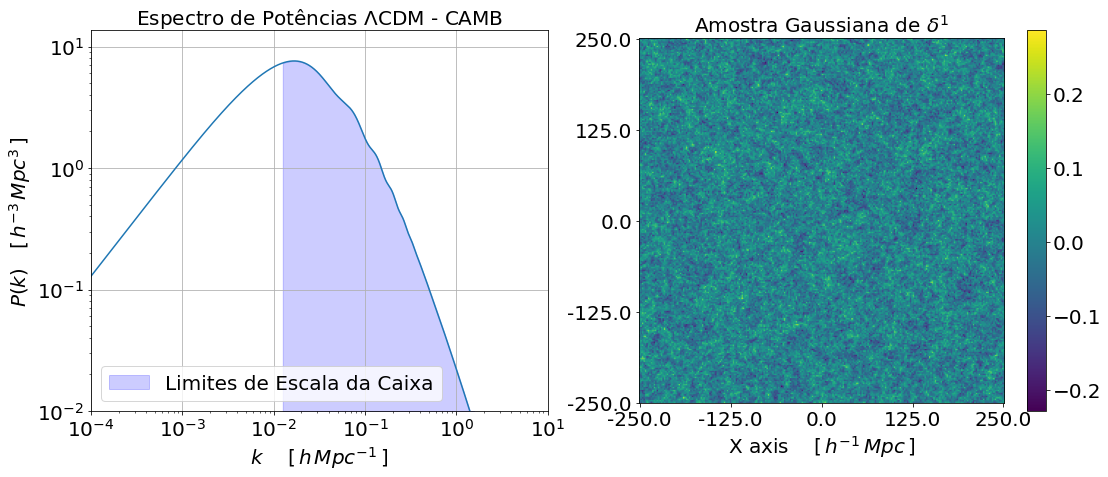

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(7)
fig.set_figwidth(18)

biasfig=1

plt.title(r"AAAA")
ax1.set_title(r"Espectro de Potências $\Lambda$CDM - CAMB",fontsize=20)
ax1.loglog(kh,P_camb(kh))
ax1.fill_between(np.linspace(k_min,k_max,1000),1e-2,P_camb(np.linspace(k_min,k_max,1000)),alpha=0.2,color='blue',label=r"Limites de Escala da Caixa")
ax1.set_ylim(bottom=1e-2)
ax1.set_ylabel(r"$P(k)$   $[\,h^{-3}\,Mpc^3\,]$",fontsize=20)
ax1.set_xlabel(r"$k$    $[\,h\,Mpc^{-1}\,]$"   ,fontsize=20)
ax1.set_xlim(left=kh[0],right=kh[-1])
ax1.grid()
ax1.legend(fontsize=20)
ax1.tick_params(labelsize=20)


ax2.set_title(r"Amostra Gaussiana de $\delta^1$",fontsize=20)
img=ax2.imshow(random_delta_tracers([biasfig],[1000])[0,:,int(N_bins/2),:],origin="lower")
cbar=fig.colorbar(img,ax=ax2)
cbar.ax.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
ax2.set_xticks(np.linspace(0,N_bins-1,5));
ax2.set_xticklabels(np.linspace(-linear_distance/2,linear_distance/2,5))
ax2.set_yticks(np.linspace(0,N_bins-1,5));
ax2.set_yticklabels(np.linspace(-linear_distance/2,linear_distance/2,5))
ax2.set_xlabel(r"X axis    $[\,h^{-1}\,Mpc\,]$" ,fontsize=20  )
plt.show()

In [12]:
def inverse_angular_ps(ls,b1,n1,r1,r2): # infinitesimal, numerical expression
    
    res=np.zeros(shape=(len(ls),len(b1),len(b1),len(r1),len(r2)),dtype='complex')
    
    for i in range(len(ls)):
        for j in range(len(r1)):
            for k in range(len(r2)):
                for u in range(len(b1)):
                    for v in range(len(b1)):
                        
                        res[i,u,v,j,k] =  (2/np.pi)*np.sum( dk1 * spherical_jn(int(ls[i]),kh[1:]*r1[j]) * spherical_jn(int(ls[i]),kh[1:]*r2[k]) * kh[1:]**2 /( kronecker(b1[u],b1[v])*Delta_L**3/n1[v] + b1[u]*b1[v]*P_camb(kh[1:]))    )
        
    return res
        

def fisher_nondeg(inv1,l1,b1,b2,b3,b4,W):
    
    l_index=int(np.where(l_1==np.double(l1))[0])
    
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])
    b3_index=int(np.where(biass==np.double(b3))[0])
    b4_index=int(np.where(biass==np.double(b4))[0])
    
    r1len=len(inv1[0,0,0,:,0])
    
    Xlen=math.comb(r1len+1, 2)      
    
    CL1_inv_theory=np.real(inv1[l_index,b1_index,b3_index,:,:])
    CL2_inv_theory=np.real(inv1[l_index,b2_index,b4_index,:,:])
    CL3_inv_theory=np.real(inv1[l_index,b1_index,b4_index,:,:])
    CL4_inv_theory=np.real(inv1[l_index,b3_index,b2_index,:,:])
    
    fishmatrix_theory=np.zeros(shape=(Xlen,Xlen))
    
    
    for i in range(Xlen):
        for j in range(Xlen):
            
            if j<=i:
                
                r1_index=np.triu_indices(r1len)[0][i]
                r2_index=np.triu_indices(r1len)[1][i]
                r3_index=np.triu_indices(r1len)[0][j]
                r4_index=np.triu_indices(r1len)[1][j]
                
                fishmatrix_theory[i,j]=((2*l1+1)/4)*(2-kronecker(b1,b2)*kronecker(r1_index,r2_index))*(2-kronecker(r3_index,r4_index))*(CL1_inv_theory[r1_index,r3_index]*CL2_inv_theory[r2_index,r4_index]+CL3_inv_theory[r1_index,r4_index]*CL4_inv_theory[r3_index,r2_index])
        
    for i in range(Xlen):
        for j in range(Xlen):    
    
            if j>i:

                fishmatrix_theory[i,j]=fishmatrix_theory[j,i]
                
    return fishmatrix_theory

def fisher_deg(inv1,l1,b1,b2,b3,b4,W):
    
    l_index=int(np.where(l_1==np.double(l1))[0])
    
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])
    b3_index=int(np.where(biass==np.double(b3))[0])
    b4_index=int(np.where(biass==np.double(b4))[0])
    
    r1len=len(inv1[0,0,0,:,0]) 
    
    Xlen=r1len**2   
    
    CL1_inv_theory=np.real(inv1[l_index,b1_index,b3_index,:,:])
    CL2_inv_theory=np.real(inv1[l_index,b2_index,b4_index,:,:])
    CL3_inv_theory=np.real(inv1[l_index,b1_index,b4_index,:,:])
    CL4_inv_theory=np.real(inv1[l_index,b3_index,b2_index,:,:])
    

    fishmatrix_theory=np.zeros(shape=(Xlen,Xlen))
    
    
    for i in range(Xlen):
        for j in range(Xlen):
            
            if j<=i:
                
                r1_index=np.unravel_index([i], (r1len,r1len))[0]
                r2_index=np.unravel_index([i], (r1len,r1len))[1]
                r3_index=np.unravel_index([j], (r1len,r1len))[0]
                r4_index=np.unravel_index([j], (r1len,r1len))[1]
                
                fishmatrix_theory[i,j]=((2*l1+1)/4)*(2-kronecker(b1,b2)*kronecker(r1_index,r2_index))*(2-kronecker(r3_index,r4_index))*(CL1_inv_theory[r1_index,r3_index]*CL2_inv_theory[r2_index,r4_index]+CL3_inv_theory[r1_index,r4_index]*CL4_inv_theory[r3_index,r2_index])
        
    for i in range(Xlen):
        for j in range(Xlen):    
    
            if j>i:
                fishmatrix_theory[i,j]=fishmatrix_theory[j,i]
                
    return fishmatrix_theory

def fisher_times_cov_nondeg(sim1,simth1,inv1,l1,b1,b2,b3,b4,W):

    covsim,covth=cov_XY(sim1,simth1,l1,b1,b2,b3,b4,W)
    fish1=fisher_nondeg(inv1,l1,b1,b2,b3,b4,W)
    
    #diag_covsim=np.diagonal(covsim)
    #diag_covth=np.diagonal(covth)
    #norm_covsim=np.outer(np.sqrt(diag_covsim),np.sqrt(diag_covsim))
    #norm_covth=np.outer(np.sqrt(diag_covth),np.sqrt(diag_covth))
    #covsim_norm=diag_covsim/norm_covsim
    #covth_norm=diag_covth/norm_covth 
    
    #diag_fish1=np.diagonal(fish1)
    #norm_fish1=np.outer(np.sqrt(diag_fish1),np.sqrt(diag_fish1))
    #fish1_norm=diag_fish1/norm_fish1
    
    identity_th_th=np.matmul(covth,fish1)
    identity_th_sim=np.matmul(covsim,fish1)
            
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.set_figheight(7)
    fig.set_figwidth(18)
    
    
    img1 = ax1.imshow(identity_th_th,cmap='bwr')
    ax1.set_title(r"Fisher (Theory) x Covariance (Theory): $F[\,\xi_{\ell,th}^{[i,j]}\,,\,\xi_{\ell,th}^{[i',j']}\,] \times \sigma_{norm}\,[\,\xi_{\ell,th}^{[i,j]}\,,\,\xi_{\ell,th}^{[i',j']}\,]$")
    
    img2 = ax2.imshow(identity_th_sim,cmap='bwr')
    ax2.set_title(r"Fisher (Theory) x Covariance (Simulation): $F[\,\xi_{\ell,th}^{[i,j]}\,,\,\xi_{\ell,th}^{[i',j']}\,] \times \sigma_{norm}\,[\,\xi_{\ell,obs}^{[i,j]}\,,\,\xi_{\ell,obs}^{[i',j']}\,]$")
    img1.set_clim(-1, 1)
    img2.set_clim(-1, 1)
    
    fig.colorbar(img1,ax=ax1,fraction=0.046, pad=0.07)
    fig.colorbar(img2,ax=ax2,fraction=0.046, pad=0.07)
    
def fisher_times_cov_deg(sim1,simth1,inv1,l1,b1,b2,b3,b4,W):
    
    covsim,covth=complete_cov_r1r2r3r4(sim1,simth1,l1,b1,b2,b3,b4,W)
    fish1=fisher_deg(inv1,l1,b1,b2,b3,b4,W)
    
    #diag_covsim=np.diagonal(covsim)
    #diag_covth=np.diagonal(covth)
    #norm_covsim=np.outer(np.sqrt(diag_covsim),np.sqrt(diag_covsim))
    #norm_covth=np.outer(np.sqrt(diag_covth),np.sqrt(diag_covth))
    #covsim_norm=diag_covsim/norm_covsim
    #covth_norm=diag_covth/norm_covth 
    
    #diag_fish1=np.diagonal(fish1)
    #norm_fish1=np.outer(np.sqrt(diag_fish1),np.sqrt(diag_fish1))
    #fish1_norm=diag_fish1/norm_fish1
    
    identity_th_th=np.matmul(covth,fish1)
    identity_th_sim=np.matmul(covsim,fish1)
    

    
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.set_figheight(7)
    fig.set_figwidth(18)
    
    img1 = ax1.imshow(identity_th_th,cmap='bwr')
    ax1.set_title(r"Fisher (Theory) x Covariance (Theory): $F[\,\xi_{\ell,th}^{i,j}\,,\,\xi_{\ell,th}^{i',j'}\,] \times \sigma_{norm}\,[\,\xi_{\ell,th}^{i,j}\,,\,\xi_{\ell,th}^{i',j'}\,]$")
    
    img2 = ax2.imshow(identity_th_sim,cmap='bwr')
    ax2.set_title(r"Fisher (Theory) x Covariance (Simulation): $F[\,\xi_{\ell,th}^{i,j}\,,\,\xi_{\ell,th}^{i',j'}\,] \times \sigma_{norm}\,[\,\xi_{\ell,obs}^{i,j}\,,\,\xi_{\ell,obs}^{i',j'}\,]$")
    img1.set_clim(-1, 1)
    img2.set_clim(-1, 1)
    
    fig.colorbar(img1,ax=ax1,fraction=0.046, pad=0.07)
    fig.colorbar(img2,ax=ax2,fraction=0.046, pad=0.07)
    
def inverse_times_aps_th(l1,b1,n1,wj,rj,rik):
    
    aps_th=Angular_PS_theory([l1],[b1],[n1],rik,rj)[0,0,0,:,:]
    
    inv_th=inverse_ps([l1],[b1],[n1],rj,rik)[0,0,0,:,:]
    
    Sum=np.zeros(shape=(len(rik),len(rik)))
    
    for i in range(len(rik)):
        
        for k in range(len(rik)):
            
            Sum[i,k]=rik[i]*rik[k]*np.sum(wj*rj[:]*aps_th[i,:]*inv_th[:,k])
     
    return Sum

def plot_inverse_times_aps_th(sum1,l1,b1,n1,wj,rj,rik):
    
    
    fig,(ax1,ax2)=plt.subplots(1,2)
    
    fig.set_figheight(7)
    fig.set_figwidth(18)
    
    img1 = ax1.imshow(sum1,cmap='bwr')
    #img1.set_clim(-1, 1)
    fig.colorbar(img1,ax=ax1,fraction=0.046, pad=0.07)
    
    for i in range(len(rik)):
        
        ax2.plot(rik,sum1[i,:],label='k=%i'%rik[i])
    ax2.set_title(r"$r_i^2\,\sum_{j}\,$",fontsize=20)
    ax2.legend()

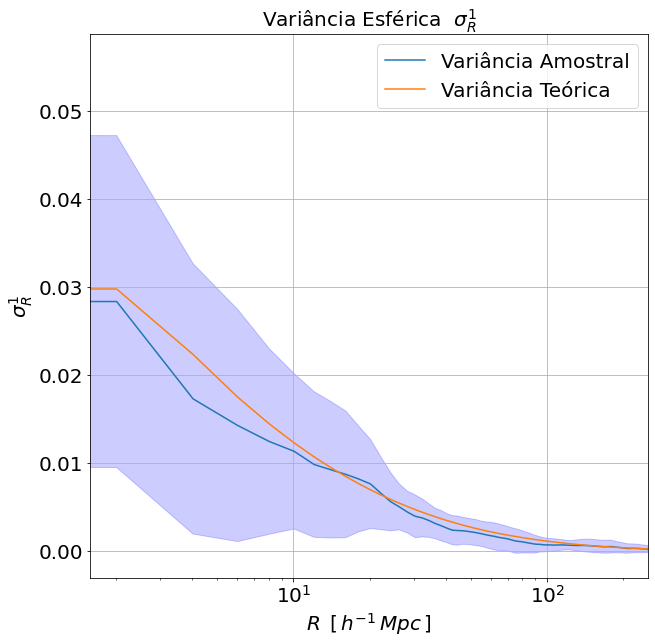

In [12]:
kh=np.logspace(-4,0,1000,10)
dk1=np.abs(kh[1:]-kh[:-1])
plot_sigma_tracer(1,1000,10)

In [13]:
def random_ps_tracers(b1,N1):
    
    
    delta_gaussian = np.random.normal(0.0, np.sqrt((linear_distance)**3*P_camb((2*np.pi/Delta_L)*grid_k))) * np.exp(1j * 2*np.pi * np.random.uniform(0, 1, grid_k.shape))
    
    delta_fourier = delta_gaussian[:,:,:N_bins//2+1] #Reality condition
    
    delta_real = (1/Delta_L)**3*np.fft.irfftn(delta_fourier)
    
    delta_tracers=np.zeros(shape=(N_bins,N_bins,N_bins))
    
    delta_fourier_tracers=np.zeros(shape=(N_bins,N_bins,N_bins))
           
    delta_tracers=(np.random.poisson(N1*(1+b1*delta_real))-N1)/N1
        
    delta_fourier_tracers=np.fft.fftn(delta_tracers)*(Delta_L)**3
                
    amp_disc=np.zeros(shape=(n_k))
     
    for i in range(n_k):
    
        amp_disc[i] = np.mean(np.abs(delta_fourier_tracers[ ((2*np.pi/Delta_L)*grid_k > k_bins[i]) & ((2*np.pi/Delta_L)*grid_k <= k_bins[i+1]) ])**2.)
        
    return amp_disc

In [14]:
# let's take 'N_samples' samples of a tracer density contrast field following the top-hat power spectrum, take its fourier
# transformation
# and compare its mean with the original top-hat


bias1=1
Nbar1=1000 # Average tracer number/bin
N_samples=10




ps_samples=np.zeros(shape=(N_samples,n_k))
ps_mean=np.zeros(n_k)
ps_var=np.zeros(n_k)

for i in range(N_samples):
    
    ps_samples[i,:]=random_ps_tracers(bias1,Nbar1)

for i in range(n_k):
    
    ps_mean[i] = np.mean(ps_samples[:,i])
    ps_var[i]=np.sqrt(np.cov(ps_samples[:,i]))
    


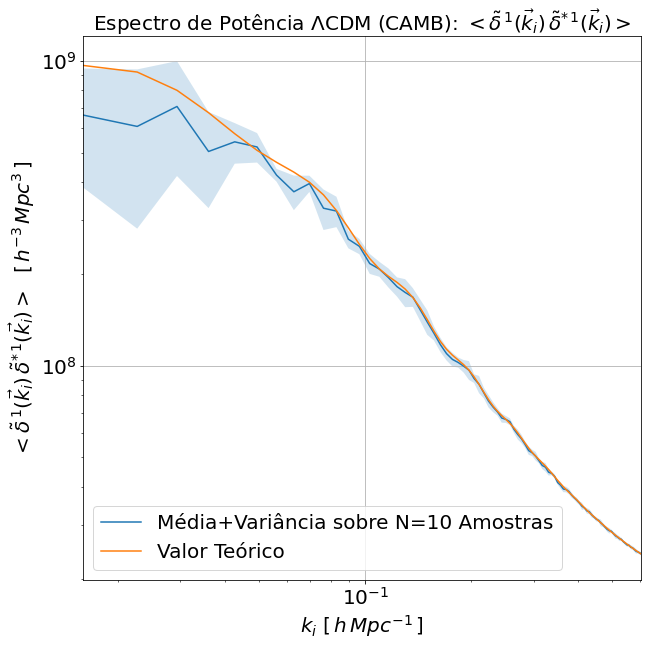

[0.68725253 0.66321813 0.88509337 0.74601366 0.94037468 1.02566799
 0.90765878 0.86204811 0.98986569 0.90411726 0.9961285  0.91724492
 0.98521456 0.96298796 0.99957202 0.99035932 0.96824882 0.97487129
 1.00270544 0.98564656 0.98174304 0.98440008 0.9758808  0.96804097
 0.96864549 0.98163363 0.98897858 1.000095   0.98718108 1.0010978
 0.99527002 0.9892727  0.99272758 0.9955662  0.98194035 1.00027386
 1.01290469 0.9900077  0.9880952  0.9942012  0.990456   0.98140001
 0.99733548 1.00068527 0.99106359 0.98028954 0.99171375 0.97992518
 0.99808157 1.00226785 0.98361888 0.98876727 0.98304008 1.00066322
 1.00573896 0.99825774 0.99669628 0.99841112 0.99709857 0.99296471
 0.99861795 0.99472896 1.00589763 0.99912048 0.99790556 0.99691785
 1.00308552 0.9991605  0.99867717 0.99512161 0.99286019 0.99577603
 1.00573011 0.99939677 0.99560103 0.99844759 0.9976447  1.00384746
 0.99734888 0.99638405 0.99424727 1.00253212 0.99728485 1.00224972
 0.99874537 0.99499464 0.99892228 1.00040432 1.00149619]


In [15]:
fig, ax1 = plt.subplots(1, 1)

fig.set_figheight(10)
fig.set_figwidth(10)

ps_theory=(linear_distance)**3*(Delta_L**3/Nbar1+bias1*bias1*P_camb(k_ctrs))

ax1.loglog(k_ctrs,ps_mean,label=r"Média+Variância sobre N=%i Amostras" %N_samples)
ax1.loglog(k_ctrs,ps_theory,label=r"Valor Teórico")
ax1.fill_between(k_ctrs,ps_mean-ps_var,ps_mean+ps_var,alpha=0.2)
ax1.set_xlabel(r"$k_i\,\,[\,h\,Mpc^{-1}\,]$",fontsize=20)
ax1.set_ylabel(r"$<\tilde{\delta}^{\,1}(\vec{k}_i)\,\tilde{\delta}^{*\,1}(\vec{k}_i)>\,\,\,\,[\,h^{-3}\,Mpc^3\,]$",fontsize=20)
ax1.set_title(r"Espectro de Potência $\Lambda$CDM (CAMB): $<\tilde{\delta}^{\,1}(\vec{k}_i)\,\tilde{\delta}^{*\,1}(\vec{k}_i)>$",fontsize=20)
ax1.set_xlim(left=k_ctrs[0],right=k_ctrs[-1])
ax1.tick_params(labelsize=20)
ax1.legend(fontsize=20)
#ax2.set_ylim(top=2e9)

#for i in range(N_samples):
#    ax1.loglog(k_ctrs,ps_samples[i,:])
    
#ax1.set_xlabel(r"$k_i\,\,[\,Mpc^{-1}\,h\,]$",fontsize=14)
#ax1.set_title(r"Espectro de Potência $\Lambda$CDM (CAMB) - Amostras $\tilde{\delta}^1$")
#ax1.set_ylabel(r"$<\tilde{\delta}^{\,1}(\vec{k}_i)\,\tilde{\delta}^{*\,1}(\vec{k}_i)>\,\,\,\,[\,Mpc^3\,h^{-3}\,]$",fontsize=14)
#ax1.set_xlim(left=k_ctrs[0],right=k_ctrs[-1])
#ax1.set_ylim(top=2e9)

ax1.grid()
#ax2.grid()

plt.show()

print(ps_mean/ps_theory)

In [ ]:
################################################## SIMULATION 1 ###########################################

biass=[1]
N_bars=[1000]
l_1=[10]
r_1=np.linspace(5,245,25)
r_2=np.linspace(5,245,25)
W=10 # Radial bin width W in Mpc h-1
N_simulations=100

inicio=time.time()

simulation_1=Angular_PS_tracers(N_simulations,l_1,biass,N_bars,r_1,r_2,W)

fim=time.time()

np.save(r"camb_DL2_W10",simulation_1)

print((fim-inicio)/60, 'minutes')

###############################################################################################

In [14]:
# Loading the simulation and computing its theoretical counterpart

biass=[1]
N_bars=[1000] # tracer density in bin^-1
l_1=[10]
r_1=np.linspace(5,245,25)
r_2=np.linspace(5,245,25)
W=10

r_inf=np.linspace(5,245,241)
simth_inf=Angular_PS_theory(l_1,biass,N_bars,r_inf,r_inf)

simulation_1_theory=Angular_PS_theory_avg(l_1,biass,N_bars,r_1,r_2,10)
#simulation_inverse_theory=inverse_angular_ps(l_1,biass,N_bars,r_1,r_2)

sim1load=np.load(r"C:\Users\Sony Vaio\camb_DL2_W10.NPY")

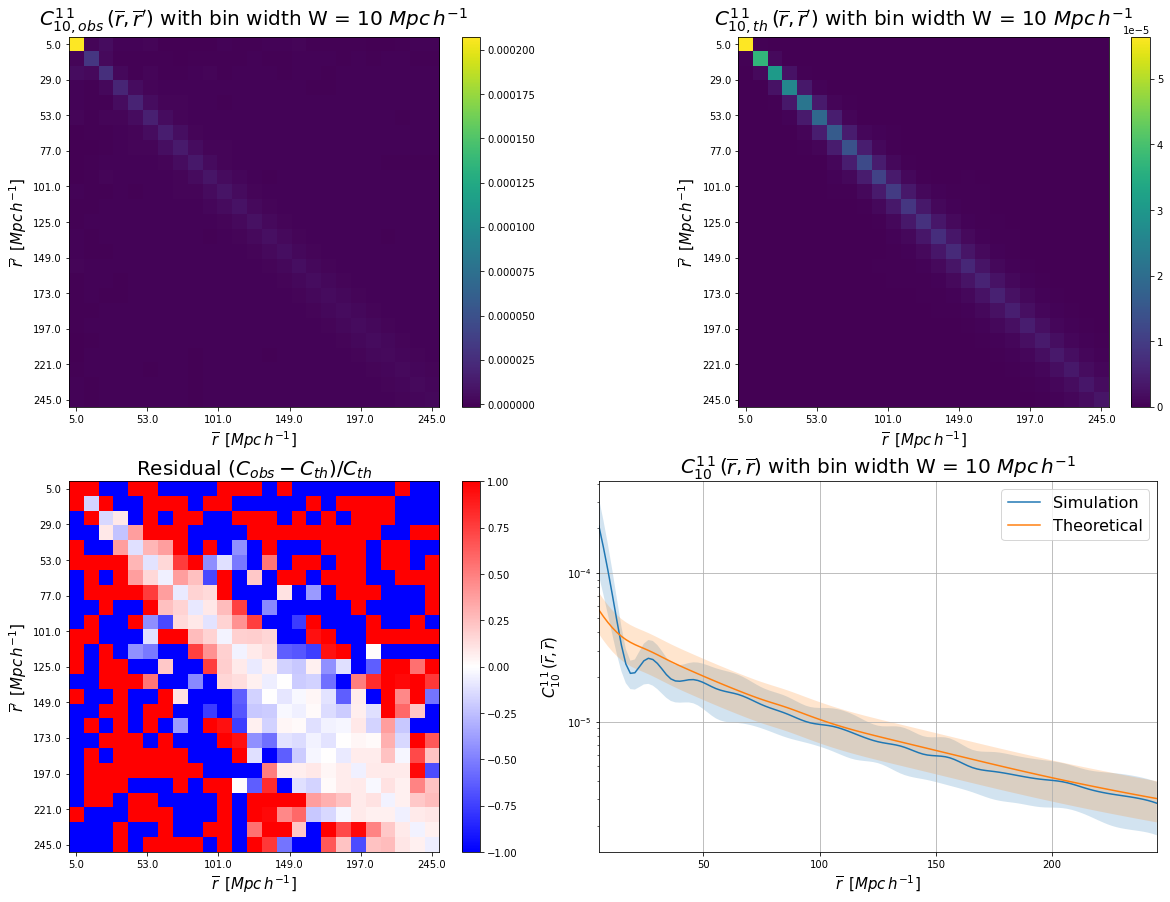

In [15]:
plot_Cl_r1r2(sim1load,1.25*simulation_1_theory,10,1,1,10)

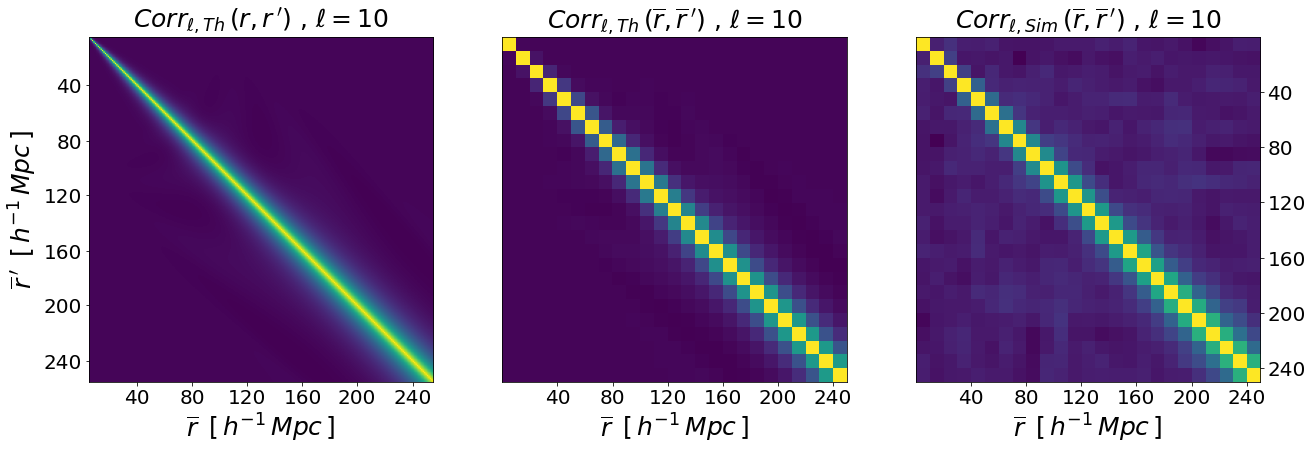

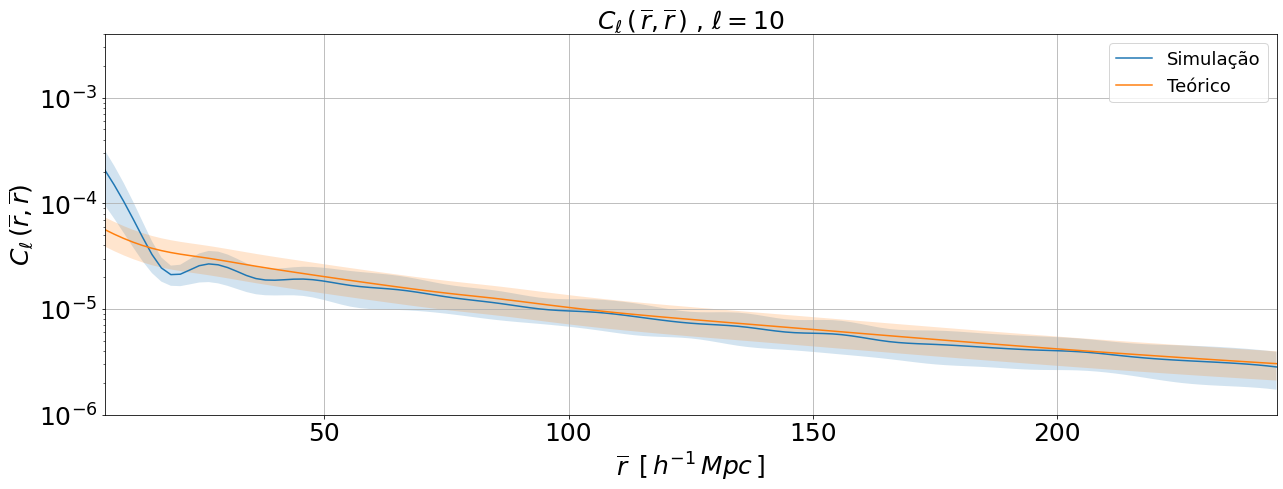

In [16]:
plot_Corr_Cl_r1r2(sim1load,1.25*simulation_1_theory,simth_inf,10,1,1,W)

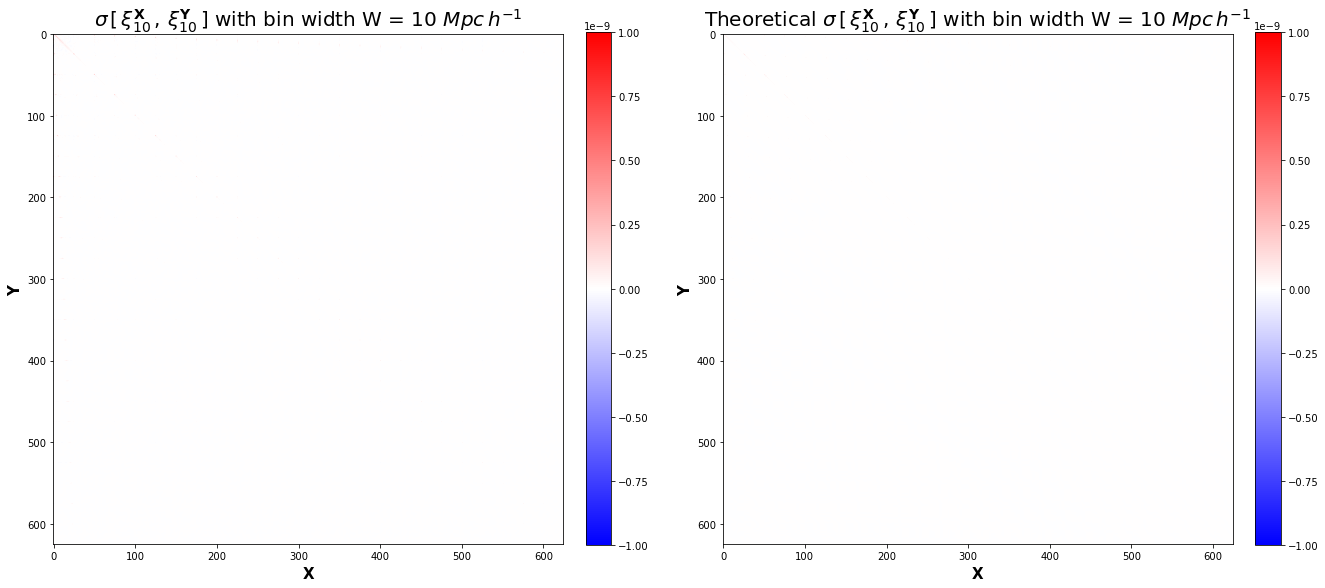

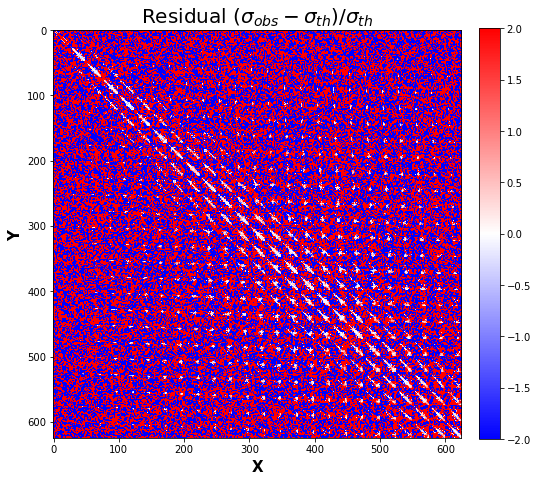

In [17]:
plot_complete_tracer_cov_XY(sim1load,1.25*simulation_1_theory,10,1,1,1,1,10)

Square Error for a Factor N=1.00 : 4066


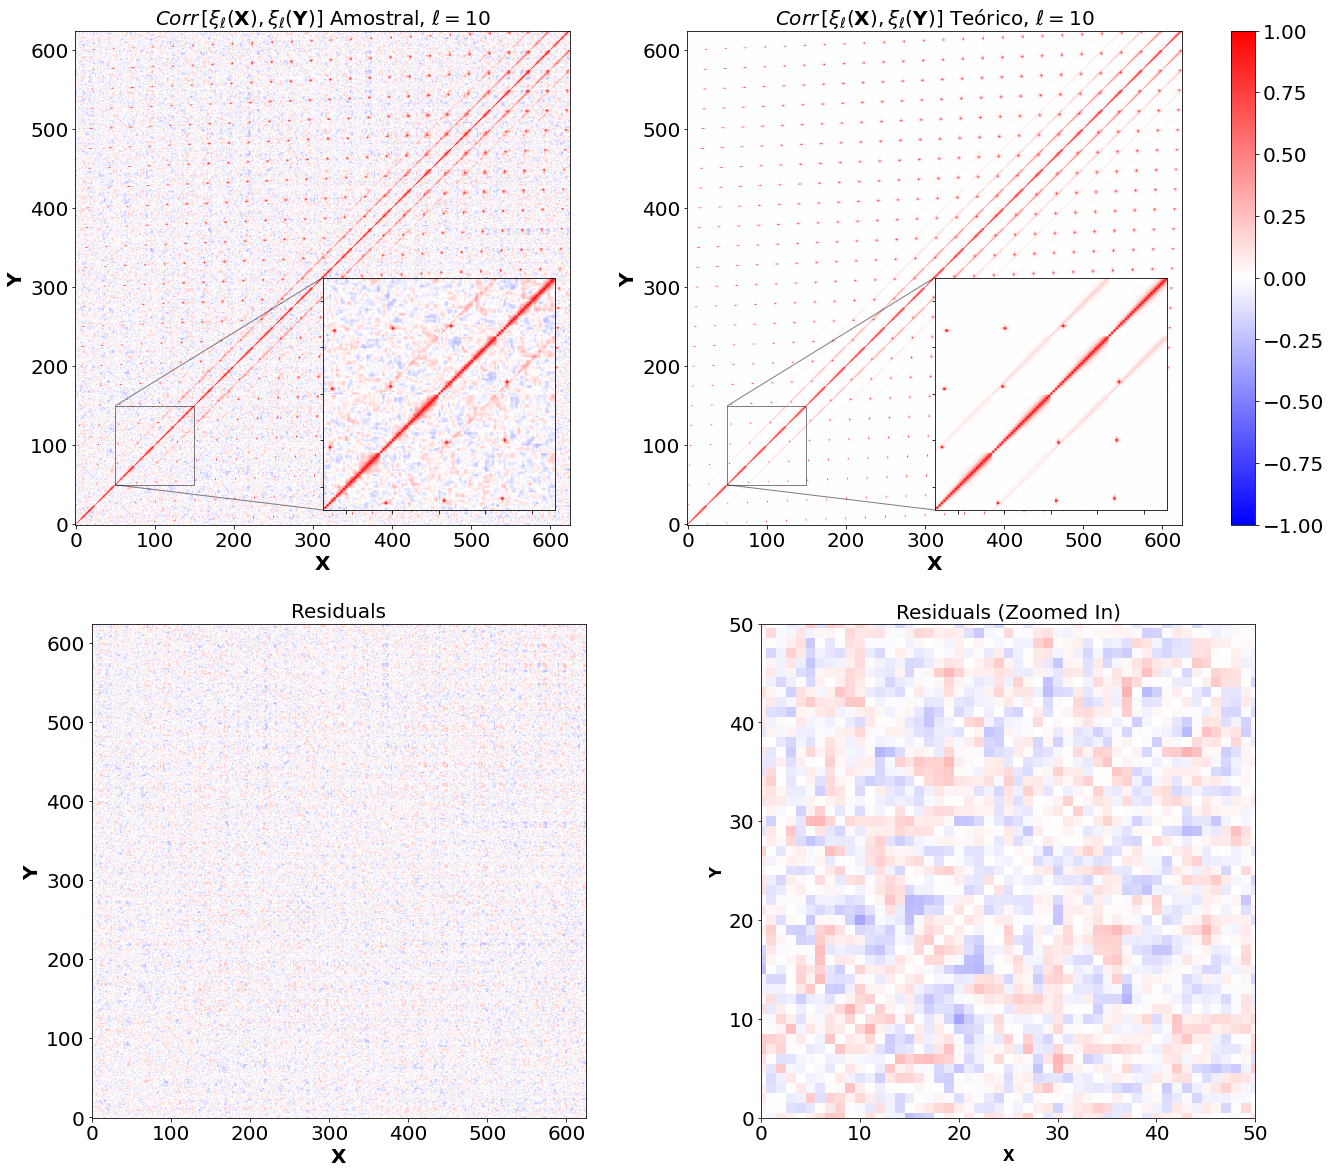

In [18]:
plot_complete_tracer_cov_XY_norm(sim1load,1.25*simulation_1_theory,10,1,1,1,1,10,1)